# Functional connectivity profiles

- Identify the connectivity profiles (areas included in the top 10% of fc connections) by subject
- Test for sex differences in connectivity profiles
- Plot connectivity profiles as a function of geodesic distance (to help understand the relation between the two)

Requires computations from scripts
- p1_connectivity_profiles_binary_matrices.py -> to compute binary matrices
- p1_connectivity_profiles_sex_diff.py -> to test the significance of sex differences in connectivity profiles (top 10% fc connections) via Chi-square test of independence and odds ratio
- p1_connectivity_profiles_mean_profiles.py -> to compute the mean connectivity profiles across all subjects and by sex (i.e., profiles with most recurrent top 10% of connections)

## Load packages

In [3]:
# General
import numpy as np
import pandas as pd
import os
import csv

# Computing
import scipy.io
from scipy import stats
from heapq import nlargest  # gives you the largest values of a list
from statsmodels.stats.multitest import fdrcorrection

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation
from enigmatoolbox.permutation_testing import spin_test, shuf_test

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

## Define directories

In [4]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'
datadir_geodesic = '/data/p_02721/geodesic_HCP/mica_pipe/output/micapipe/'

resdir_hcp = '/data/p_02667/sex_diff_gradients/results/HCP/'
resdir_fig = '/data/p_02667/sex_diff_gradients/results/figures/'

In [5]:
path_list = os.listdir(datadir_geodesic)
path_list.sort()

## Import functions

In [6]:
%run p1_myfunctions.ipynb

# Data

## Import the Yeo 7 network coding for the Schaefer 400 parcellation scheme 

(i.e., which network each parcel belongs to)



- **So a parcel cannot belong to more than 1 network..? LIMITATION NO? -> Yes. Shanmugan et al. (2022) for example use loading onto a network (i.e., not discrete)** 

In [7]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN

with open(datadir+'yeo_7.csv') as f:
    reader = csv.reader(f)
    yeo7_networks = list(reader)[0]  # need [0] because the network values are contained in double brackets [[ ]]

Plotting the 7 Yeo networks on cortical surface

**TO DO:**
- no option of a map with 7 colors..? https://matplotlib.org/stable/tutorials/colors/colormaps.html
- there must be a better way of labelling the maps with actual names of networks (ie categorical)? maybe not, not the purpose of this plot hemispheres function


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


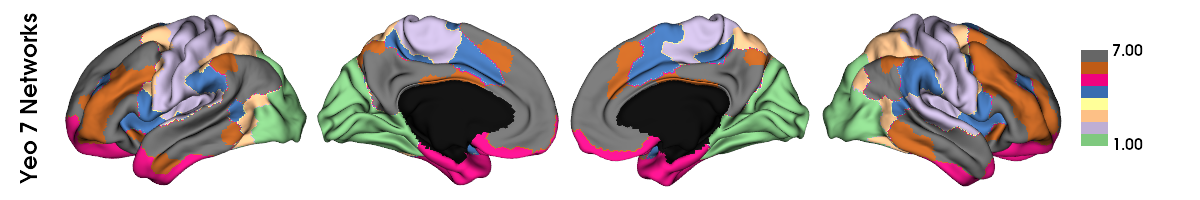

In [8]:
# need the the yeo network values (=dummy coding) to be in array format & float type in order to map_to_labels
yeo7_networks_array = []

for i in yeo7_networks:
    yeo7_networks_array.append(float(i))

yeo7_networks_array = np.asarray(yeo7_networks_array)



# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

networks = map_to_labels(yeo7_networks_array, labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

plot_hemispheres(surf_lh, surf_rh, array_name=networks, embed_nb = True, size=(1200, 200), cmap='Accent', color_bar=True, label_text=['Yeo 7 Networks'], zoom=1.55)


## Network labels ('Accent' cmap):
# 1 visual (green)
# 2 sensory motor (purple)
# 3 dorsal attention (beige)
# 4 ventral attention (blue)
# 5 limbic (fuchsia)
# 6 fronto parietal (brown)
# 7 DMN (grey)

This palette is to be used for every time that Yeo networks are displayed in color (except (a) for showing the networks plotted on the hemispheres - this dictionary doesn't work as cmap for plot_hemispheres; (b) the pie charts - dictionary format not recognized)

In [9]:
# original Yeo network colors
palette_labeled_networks = {'DMN': 'indianred',  
                            'dorsal attention' : 'forestgreen',  
                            'fronto parietal' : 'orange',  
                            'limbic' : 'lemonchiffon',  
                            'sensory motor' : 'steelblue',
                            'ventral attention' : 'orchid', 
                            'visual' : 'darkorchid'} 

This is not needed for the raincloud plot, just for the scatterplot G1 v G2 displaying networks

In [10]:
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks:
    if i == '1':
        yeo7_networks_array_labels.append('visual')
    elif i == '2':
        yeo7_networks_array_labels.append('sensory motor')
    elif i == '3':
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == '4':
        yeo7_networks_array_labels.append('ventral attention')
    elif i == '5':
        yeo7_networks_array_labels.append('limbic')
    elif i == '6':
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == '7':
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)

In [11]:
network_names = ["visual", "sensory motor", "DMN", "dorsal attention", "ventral attention", "limbic", "fronto parietal"]

print("Number of parcels in each Yeo network:")
for i in range(len(network_names)):
    print(f"- {network_names[i]}: {yeo7_networks_array_labels.tolist().count(network_names[i])}")

Number of parcels in each Yeo network:
- visual: 61
- sensory motor: 77
- DMN: 90
- dorsal attention: 46
- ventral attention: 47
- limbic: 26
- fronto parietal: 53


## Fetch fsaverage parcellation (20484 vertices) coded for Schaefer 400 parcels - for Spin permutation tests

Spin permutation testing: https://enigma-toolbox.readthedocs.io/en/latest/pages/08.spintest/index.html -> requires data to be in fsaverage surface (not feasible with Schaefer parcellation)

**NOTE: schaefer_400_fs5 == 0 corresponds to midline (labels go from 0-400) -> disregard 0 in calculations and plotting**

In [12]:
# fetch the fsaverage parcellation labeling each of fsaverage5's 20484 vertices with its corresponding Schaefer parcel
schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400)

## Load final subject list

In [13]:
HCP_sub_list_final = np.genfromtxt(datadir+'HCP_sub_list_final.csv', delimiter=',')
HCP_sub_list_final = np.array([str(int(e)) for e in HCP_sub_list_final])

## Load fc data

In [14]:
# fc matrices
scipy.io.whosmat(datadir+'fc_matrices/fc_matrices.mat')

[('HCP_fc_matrices', (1014, 400, 400), 'double'),
 ('HCP_sub_list_fc', (1014,), 'char'),
 ('GSP_fc_matrices', (1568, 400, 400), 'double'),
 ('GSP_sub_list_fc', (1568,), 'char')]

In [15]:
# taking the list of subjects that have fc data
HCP_sub_list_fc = scipy.io.loadmat(datadir+'fc_matrices/fc_matrices.mat')['HCP_sub_list_fc']

# taking the fc matrices from the mat file
fc_matrices_full = scipy.io.loadmat(datadir+'fc_matrices/fc_matrices.mat')['HCP_fc_matrices']

### Get subsample of fc matrices that has full data (matching HCP_sub_list_final)

In [16]:
# list that will contain the fc matrices in final sample
fc_matrices = []

for i in range(len(HCP_sub_list_fc)):
    if HCP_sub_list_fc[i] in HCP_sub_list_final:
        
        # append this subjects' list of fc matrices to the list of fc matrices in final sample
        fc_matrices.append(fc_matrices_full[i])
    
fc_matrices = np.array(fc_matrices)

In [17]:
fc_matrices.shape

(1000, 400, 400)

## Geodesic distance data 

In [18]:
mean_geodesic_distances_full = np.genfromtxt(datadir+'geodesic_distance/mean_geodesic_distances.csv', delimiter=',')

In [19]:
mean_geodesic_distances_full.shape

(1010, 400)

In [20]:
HCP_sub_list_geodesic = pd.read_csv(datadir+'geodesic_distance/HCP_sub_list_geodesic.csv', header = None)[0].to_list()
HCP_sub_list_geodesic = [str(e) for e in HCP_sub_list_geodesic]
len(HCP_sub_list_geodesic)

1010

### Get subsample of geodesic distance data that has full data (matching HCP_sub_list_final)

In [21]:
# list that will contain the mean of the top geodesic distances in final sample
mean_geodesic_distances = []

for i in range(len(HCP_sub_list_geodesic)):
    if HCP_sub_list_geodesic[i] in HCP_sub_list_final:
        
        # append this subjects' list of mean top geodesic distances to the list of mean of the top geodesic distances in final sample
        mean_geodesic_distances.append(mean_geodesic_distances_full[i])
        
    
mean_geodesic_distances = np.array(mean_geodesic_distances)

In [22]:
mean_geodesic_distances.shape

(1000, 400)

## Load demographics data to retrieve sex of subjects

In [23]:
HCP_demographics_cleaned_final = pd.read_csv(resdir_hcp+'demographics_cleaned_final.csv', index_col=0)

In [24]:
HCP_demographics_cleaned_final

,Subject,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,Race,...,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,sex_num,TwinStatus,TwinStatus_num,Family_ID_num
1,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,White,...,49.7,72.63,72.03,1.84,0.0,1.84,0,sibling,2,115
2,100307,27,True,NotMZ,MZ,51488_81352,51488,81352,NaN,White,...,38.6,71.69,71.76,1.76,0.0,1.76,1,MZ,0,149
3,100408,33,True,MZ,MZ,51730_81594,51730,81594,NaN,White,...,52.6,114.01,113.59,1.76,2.0,1.68,0,MZ,0,38
4,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,White,...,38.6,84.84,85.31,1.92,1.0,1.88,0,DZ,1,8
5,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,Black or African Am.,...,38.6,123.80,123.31,1.80,0.0,1.80,1,MZ,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,White,...,38.6,101.63,99.26,1.80,0.0,1.80,1,sibling,2,340
1201,992774,35,True,NotTwin,,51345_81210,51345,81210,NaN,White,...,50.1,107.17,103.55,1.76,0.0,1.76,0,sibling,2,272
1202,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,White,...,38.6,84.07,84.25,1.80,1.0,1.76,1,sibling,2,341
1203,994273,30,True,NotTwin,,52364_82227,52364,82227,NaN,White,...,63.8,110.65,109.73,1.80,1.0,1.76,0,sibling,2,200


# Binary matrices

This has been computed by p1_connectivity_profiles_binary_matrices.py

Explanation:
- for each subject, compute 400x400 matrices with binary coding showing whether an fc connection is in the top 10% (out of 200 -> top 20) connections for a given area (in a row) 
- coding: in top 10% of connections (1), NOT in the top 10% of connections (0)

### Loading from mat files

In [21]:
# binary matrices
scipy.io.whosmat(resdir_hcp+'binary_top_fc.mat')

[('binary_top_fc', (1000, 400, 400), 'int64'),
 ('binary_top_fc_M', (464, 400, 400), 'int64'),
 ('binary_top_fc_F', (536, 400, 400), 'int64')]

In [25]:
# loading the full sample binary matrices
binary_top_fc = scipy.io.loadmat(resdir_hcp+'binary_top_fc.mat')['binary_top_fc']

# loading the binary matrices by sex
binary_top_fc_M = scipy.io.loadmat(resdir_hcp+'binary_top_fc.mat')['binary_top_fc_M']
binary_top_fc_F = scipy.io.loadmat(resdir_hcp+'binary_top_fc.mat')['binary_top_fc_F']

just a check to see that indeed took 10% of top connections (out of 200 parcels)

In [27]:
np.count_nonzero(binary_top_fc[0][0] == 1)

20

#### Full matrix

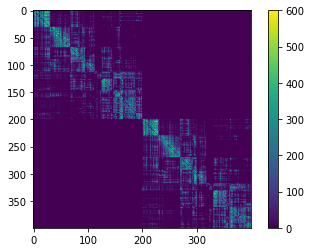

(464, 400, 400)

In [169]:
plt.imshow(sum(binary_top_fc_M))
plt.colorbar()
plt.clim(0, 600)
plt.show()

binary_top_fc_M.shape

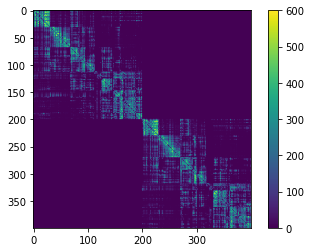

(536, 400, 400)

In [170]:
plt.imshow(sum(binary_top_fc_F))
plt.colorbar()
plt.clim(0, 600)
plt.show()

binary_top_fc_F.shape

#### Matrix left hemisphere

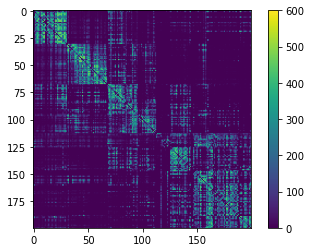

In [96]:
plt.imshow(sum(binary_top_fc_M)[:200, :200])
plt.colorbar()
plt.clim(0, 600)
plt.show()

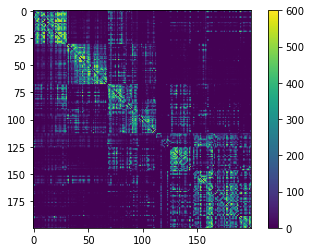

In [99]:
plt.imshow(sum(binary_top_fc_F)[:200, :200])
plt.colorbar()
plt.clim(0, 600)
plt.show()

# Test sex differences in connectivity profiles 

Via:
- Chi-square test of indepndence (H0) of variables in contingency table to test the indepdence of variables "sex" (rows) and "area is/is not in top 10% of functional connections" (columns) -> non-independence == sex differences in top 10% of connections
- Odds Ratio (effect size)

###  Compute sex differences (measures: Chi-square test of indipendence of variables FDR-corrected q values and odds ratio)

This has been computed by p1_connectivity_profiles_sex_diff.py

Explanation:
- for every row (parcel) in binary matrix, for ever parcel in row of binary matrix -> make a contingency table 
- for contingency table, need to a) count the number of males and females (separately) that have this area marked (with a 1) as being one of the top 10% of connections (simply take the sum across subjects for this cell in matrix given that if area is not in top 10% of connections, it is marked with 0) and b) deduce the counts of subjects for which this areas is not part of top 10% connections
- With contingency table, can compute a) Chi-square test of independence of variables, b) (from contents of table) the Odds Ratio


Odds Ration interpretations: Odds Ratio indicating a) effect size, b) direction of effect
- OR = 1: odds of connection being part of top 10% connections to the seed is the same between males and females
- OR > 1: odds of connection being part of top 10% connections to the seed is greater in males than in females
- OR < 1 odds of connection being part of top 10% connections to the seed is grater in females than in males
*Interpretations of OR (that I corrected) - there should be no inf or nan*
- *OR = nan would mean that there are just zeroes in at least one column (either (Cm + Cf == 0) or (NCm + NCf == 0)) - which throws an error in the computation of the chi-square test and therefore we automatically assign p-val as being not significant (1) - so I hard coded it as OR = 1 (no sex difference)*
- *OR = inf would mean that there was a division by zero in the coputation of the OR (Cm/NCm)/(Cf/NCf) BUT in such cases I hardcoded a division by 0.5 in order to make the OR values more interpretable for plotting (https://www.researchgate.net/post/How_to_calculate_OR_odd_ratio_if_one_of_groups_is_0_in_a_case-control_study)*


### Loading from arrays

In [26]:
# significance test (we will use the FDR-corrected q values only, p values are for indicative purposes only
chisquare_pval_matrix = np.genfromtxt(resdir_hcp+'top_fc_sex_diff_chisquare_pval_matrix.csv', delimiter=',')
chisquare_qval_matrix = np.genfromtxt(resdir_hcp+'top_fc_sex_diff_chisquare_qval_matrix.csv', delimiter=',')

# OR
OR_matrix = np.genfromtxt(resdir_hcp+'top_fc_sex_diff_OR_matrix.csv', delimiter=',') 

### Display raw results

In [206]:
np.count_nonzero(chisquare_pval_matrix < 0.05)

8371

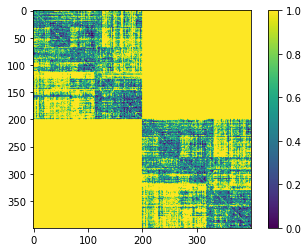

In [207]:
plt.imshow(chisquare_pval_matrix)
plt.colorbar()
#plt.clim(0, 0.1)
plt.show()

In [211]:
np.count_nonzero(chisquare_qval_matrix < 0.05)

2004

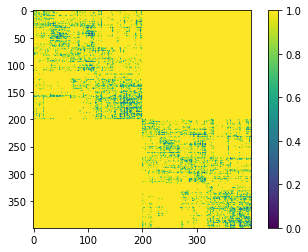

In [131]:
plt.imshow(chisquare_qval_matrix)
plt.colorbar()
#plt.clim(0, 0.1)
plt.show()

significant differences shown only

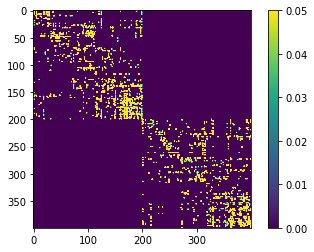

In [175]:
plt.imshow(chisquare_qval_matrix < 0.05)
plt.colorbar()
plt.clim(0, 0.05)
plt.show()

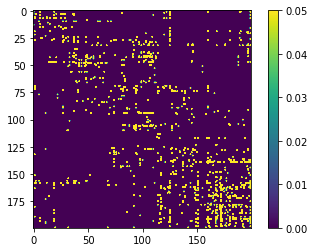

In [187]:
plt.imshow(chisquare_qval_matrix[:200, :200] < 0.05)
plt.colorbar()
plt.clim(0, 0.05)
plt.show()

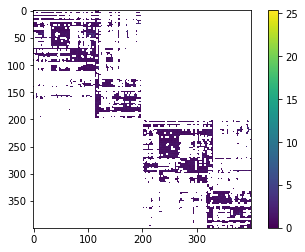

In [168]:
plt.imshow(OR_matrix)
plt.colorbar()
#plt.clim(0, 0.1)
plt.show()

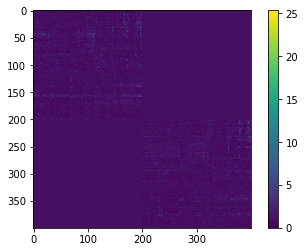

In [46]:
plt.imshow(OR_matrix)
plt.colorbar()
#plt.clim(0, 0.1)
plt.show()

In [44]:
OR_matrix

array([[1.        , 0.69146996, 0.84396797, ..., 1.        , 1.        ,
        1.        ],
       [0.46813187, 1.        , 0.00431965, ..., 1.        , 1.        ,
        1.        ],
       [0.68787879, 1.33727811, 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 0.68017429,
        0.28571429],
       [1.        , 1.        , 1.        , ..., 0.73953488, 1.        ,
        0.56886346],
       [1.        , 1.        , 1.        , ..., 0.92685034, 1.01202339,
        1.        ]])

In [212]:
np.nanmax(OR_matrix)

25.36117381489842

In [214]:
np.nanmin(OR_matrix)

0.0

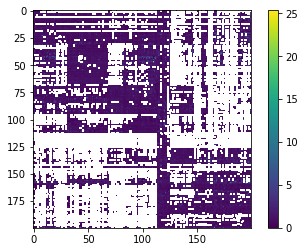

In [216]:
plt.imshow(OR_matrix[:200, :200])
plt.colorbar()
#plt.clim(0, 0.1)
plt.show()

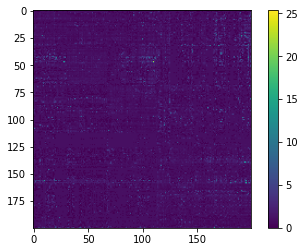

In [48]:
plt.imshow(OR_matrix[:200, :200])
plt.colorbar()
#plt.clim(0, 0.1)
plt.show()

### Display results in interpretable way

#### Parcels showing the greatest sex differences in connectivity profiles -> Number of connections (per seed parcel, i.e. out of /400 connections) that show a significant sex difference)

In [27]:
# make a vector including, per seed, the count (number of connections) that show a significant sex difference

num_sig_q_vals_per_area = []

for i in range(400):
    num_sig_q_vals_per_area.append(np.count_nonzero(chisquare_qval_matrix[i] < 0.05))
    
num_sig_q_vals_per_area = np.array([float(e) for e in num_sig_q_vals_per_area])    

In [24]:
num_sig_q_vals_per_area

array([ 0.,  9.,  3.,  8.,  6.,  0.,  2., 14.,  0.,  1.,  9.,  1.,  2.,
        1.,  1.,  5.,  4.,  1.,  0.,  7.,  2.,  5.,  3.,  3.,  8.,  4.,
        4., 12.,  7., 10.,  1.,  7., 21.,  0.,  0.,  3.,  1.,  2.,  5.,
        9.,  2.,  3., 18., 20.,  5.,  7.,  3., 22., 13.,  1.,  9.,  5.,
        1.,  1.,  0.,  0.,  8.,  1.,  0.,  1.,  1.,  1.,  5.,  3.,  1.,
        6.,  7.,  0.,  0., 10.,  8.,  6.,  4.,  6., 14.,  1.,  4.,  2.,
        2.,  1.,  3.,  4.,  3.,  2.,  4.,  0.,  4.,  1.,  4.,  8.,  4.,
        2.,  3.,  4., 20.,  4.,  0.,  0.,  3.,  0.,  3.,  2.,  2.,  1.,
        4., 11., 15.,  0.,  4.,  2.,  7.,  0.,  0.,  2.,  0.,  0.,  1.,
        9.,  0.,  0.,  0.,  0.,  0.,  3.,  1.,  1.,  4., 12.,  7.,  2.,
        6.,  7.,  6.,  2.,  3.,  2.,  6., 14.,  6., 33.,  2.,  2.,  2.,
       11.,  4.,  1.,  3.,  3.,  7.,  4.,  4.,  5.,  2.,  5.,  4.,  1.,
       15.,  4., 24.,  1., 17.,  4., 17., 15.,  7.,  8.,  4.,  6.,  2.,
       14., 14.,  5., 10.,  2.,  4.,  7.,  2.,  2., 19.,  9., 11

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


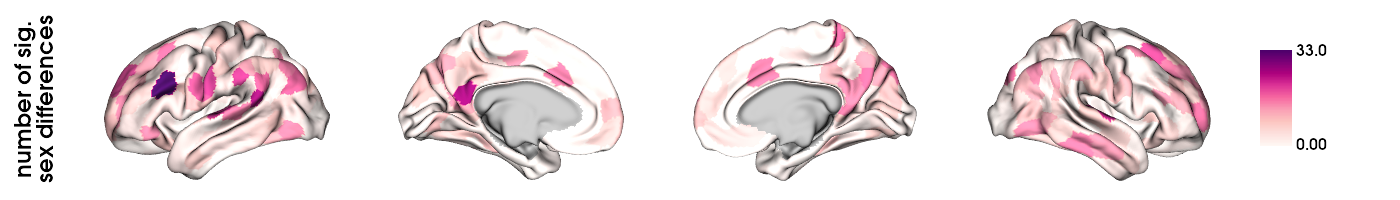

In [25]:
# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0


num_sig_q_vals_per_area_mapped_to_labels = map_to_labels(num_sig_q_vals_per_area, labeling, mask=mask, fill=np.nan)  

num_sig_q_vals_per_area_plotted_hemispheres = plot_hemispheres(
    surf_lh, 
    surf_rh, 
    array_name = num_sig_q_vals_per_area_mapped_to_labels, 
    embed_nb = True, 
    size = (1400,200), 
    cmap = "RdPu",  
    color_bar = True, 
    #color_range='sym',
    nan_color = (0.7, 0.7, 0.7, 1),
    label_text = ["number of sig.\nsex differences"],
    zoom = 1.45, 
    screenshot = False,
    #filename = resdir_fig+'HCP_geo'+'_plotted_hemispheres_mean_distances.png'
)

num_sig_q_vals_per_area_plotted_hemispheres

##### Identify that outliar

In [26]:
np.where(num_sig_q_vals_per_area == 33)

(array([139]),)

In [212]:
from nilearn.datasets import fetch_atlas_schaefer_2018

schaefer400_labels = fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=1, data_dir=None, base_url=None, resume=True, verbose=1)['labels']

In [213]:
schaefer400_labels[139]

b'7Networks_LH_Cont_PFCl_6'

##### Significant sex differences by network (of seed region)

In [23]:
# make a vector including, per seed, the count (number of connections) that show a significant sex difference

num_sig_q_vals_per_area = []

for i in range(400):
    num_sig_q_vals_per_area.append(np.count_nonzero(chisquare_qval_matrix[i] < 0.05))
    
num_sig_q_vals_per_area = np.array([float(e) for e in num_sig_q_vals_per_area])    

In [29]:
yeo7_networks_array_labels

array(['visual', 'visual', 'visual', 'visual', 'visual', 'visual',
       'visual', 'visual', 'visual', 'visual', 'visual', 'visual',
       'visual', 'visual', 'visual', 'visual', 'visual', 'visual',
       'visual', 'visual', 'visual', 'visual', 'visual', 'visual',
       'visual', 'visual', 'visual', 'visual', 'visual', 'visual',
       'visual', 'sensory motor', 'sensory motor', 'sensory motor',
       'sensory motor', 'sensory motor', 'sensory motor', 'sensory motor',
       'sensory motor', 'sensory motor', 'sensory motor', 'sensory motor',
       'sensory motor', 'sensory motor', 'sensory motor', 'sensory motor',
       'sensory motor', 'sensory motor', 'sensory motor', 'sensory motor',
       'sensory motor', 'sensory motor', 'sensory motor', 'sensory motor',
       'sensory motor', 'sensory motor', 'sensory motor', 'sensory motor',
       'sensory motor', 'sensory motor', 'sensory motor', 'sensory motor',
       'sensory motor', 'sensory motor', 'sensory motor', 'sensory motor

#### Network breakdown of connections showing significant sex differences in their odds of being in the top 10% of connections to the seed

##### Networks of **seed** regions

Number of significant sex differences in odds of connection being in top 10% connections per seed (out of 400x400 -> 160000 connections): 2004

Number of significant sex differences where odds of connection being in top 10% is male > female (OR > 1): 987
Number of significant sex differences where odds of connection being in top 10% is female > male (OR < 1): 1017

Number of significant sex differences in each Yeo network of the seed region (across sexes):
- visual: 13.57% of overall significance
- sensory motor: 17.37% of overall significance
- DMN: 33.83% of overall significance
- dorsal attention: 9.63% of overall significance
- ventral attention: 9.83% of overall significance
- limbic: 1.45% of overall significance
- fronto parietal: 14.32% of overall significance





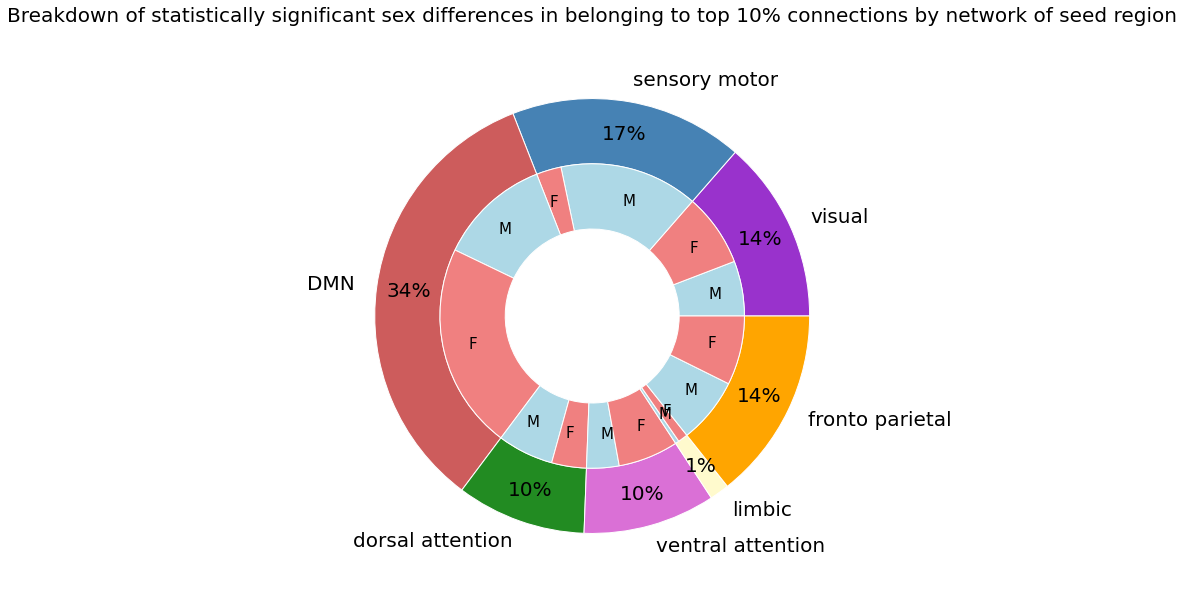

Number of significant parcels by sex:
visual - Male: 117, Female: 155
sensory motor - Male: 295, Female: 53
DMN - Male: 239, Female: 439
dorsal attention - Male: 119, Female: 74
ventral attention - Male: 69, Female: 128
limbic - Male: 8, Female: 21
fronto parietal - Male: 140, Female: 147





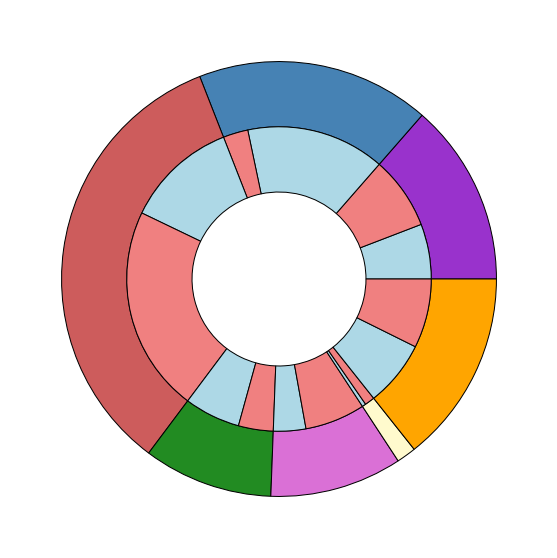

In [109]:
count_sig = 0
count_sig_M = 0
count_sig_F = 0
count_sig_per_network = {"visual": 0, "sensory motor": 0, "DMN": 0, "dorsal attention": 0, "ventral attention": 0, "limbic": 0, "fronto parietal": 0}
count_sig_per_network_bysex = {"visual": [0,0], "sensory motor": [0,0], "DMN": [0,0], "dorsal attention": [0,0], "ventral attention": [0,0], "limbic": [0,0], "fronto parietal": [0,0]} # M: [0], F: [1]

# iterate over rows (seed regions)
for i in range(400):
    
    # iterate over columns (target regions)
    for j in range(400):
    
        if chisquare_qval_matrix[i][j] < 0.05:
            count_sig += 1
            count_sig_per_network[yeo7_networks_array_labels[i]] += 1  # network of seed region

            # positive OR means male odds > female odds: increment the first item of the list for given label
            if OR_matrix[i][j] > 1:
                count_sig_M += 1
                count_sig_per_network_bysex[yeo7_networks_array_labels[i]][0] += 1  # network of seed region

            # negative OR means female odds > male odds: increment the second item of the list for the given label
            else:
                count_sig_F += 1
                count_sig_per_network_bysex[yeo7_networks_array_labels[i]][1] += 1  # network of seed region
           
                
print(f"Number of significant sex differences in odds of connection being in top 10% connections per seed (out of 400x400 -> 160000 connections): {count_sig}\n")
print(f"Number of significant sex differences where odds of connection being in top 10% is male > female (OR > 1): {count_sig_M}")
print(f"Number of significant sex differences where odds of connection being in top 10% is female > male (OR < 1): {count_sig_F}\n")
print("Number of significant sex differences in each Yeo network of the seed region (across sexes):")

# using ANSI escape sequences to underline -> bold: \033[1m ; underline: \033[4m ; end: \033[0m
for i in range(len(count_sig_per_network)):
    print(f"- {list(count_sig_per_network.keys())[i]}: \033[1m{round(count_sig_per_network[list(count_sig_per_network.keys())[i]]*100/count_sig,2)}%\033[0m of overall significance")

print("\n\n")




### Nested pie chart

## make data plottable
list_count_sig_per_network_bysex = []

for label in count_sig_per_network_bysex:
    list_count_sig_per_network_bysex.append(count_sig_per_network_bysex[label])

vals = np.array(list_count_sig_per_network_bysex)

outer_colors = ["darkorchid",  # visual
                "steelblue",  # sensorimotor
                "indianred",  # dmn
                "forestgreen",  # dorsal attention
                "orchid",  # ventral attention
                "lemonchiffon",  # limbic
                "orange"]  # frontoparietal



inner_color_plus = 'lightblue'
inner_color_minus = 'lightcoral'



inner_colors = [inner_color_plus, inner_color_minus,  # visual
                inner_color_plus, inner_color_minus,  # sensorimotor
                inner_color_plus, inner_color_minus,  # dmn
                inner_color_plus, inner_color_minus,  # dorsal attention
                inner_color_plus, inner_color_minus,  # ventral attention
                inner_color_plus, inner_color_minus,  # limbic
                inner_color_plus, inner_color_minus]  #frontoparietal

fig, ax = plt.subplots(figsize=(15, 10))

size = 0.3

## plot outer pie
ax.pie(vals.sum(axis=1), radius=1, labels=count_sig_per_network_bysex.keys(), colors=outer_colors, autopct='%.0f%%', pctdistance=0.85,
       wedgeprops=dict(width=size, edgecolor='white'),  textprops={'fontsize': 20})

## plot inner pie

# make a list (in order) containing the labels (sex - hardcoded) only for sections that have more than 1 count (otherwise label is placeholder: blank)

labels_only_show_non_null = []

for network in list_count_sig_per_network_bysex:

    # males
    if network[0] > 0:
        labels_only_show_non_null.append('M')
    else:
        labels_only_show_non_null.append('')

    # females
    if network[1] > 0:
        labels_only_show_non_null.append('F')
    else:
        labels_only_show_non_null.append('')

ax.pie(vals.flatten(), radius=1-size, labels=labels_only_show_non_null, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='white'),  textprops={'fontsize': 15},  labeldistance=0.78)

ax.set(aspect="equal")
ax.set_title(f'Breakdown of statistically significant sex differences in belonging to top 10% connections by network of seed region', y=1.03, fontsize=20)

plt.show()

print('Number of significant parcels by sex:')
for network in count_sig_per_network_bysex:
    print(f"{network} - Male: {count_sig_per_network_bysex[network][0]}, Female: {count_sig_per_network_bysex[network][1]}")

print("\n\n")



### plot outer and inner pie (without labels)

fig, disp = plt.subplots(figsize=(15, 10))
size = 0.3

disp.pie(vals.sum(axis=1), radius=1, colors=outer_colors, pctdistance=0.85,
       wedgeprops=dict(width=size, edgecolor='black'),  textprops={'fontsize': 20})

disp.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='blacK'),  textprops={'fontsize': 15},  labeldistance=0.78)

disp.set(aspect="equal")

plt.show()


## save figure in directory 
fig.savefig(resdir_fig+'HCP_connectivity_profile_pie_chart_sex_diff_seed_netw.png', dpi=300)

print("\n\n")

##### Networks of **target** regions

Number of significant sex differences in odds of connection being in top 10% connections per seed (out of 400x400 -> 160000 connections): 2004

Number of significant sex differences where odds of connection being in top 10% is male > female (OR > 1): 987
Number of significant sex differences where odds of connection being in top 10% is female > male (OR < 1): 1017

Number of significant sex differences in each Yeo network of the target region (across sexes):
- visual: 8.93% of overall significance
- sensory motor: 12.18% of overall significance
- DMN: 35.78% of overall significance
- dorsal attention: 7.78% of overall significance
- ventral attention: 14.57% of overall significance
- limbic: 8.53% of overall significance
- fronto parietal: 12.23% of overall significance





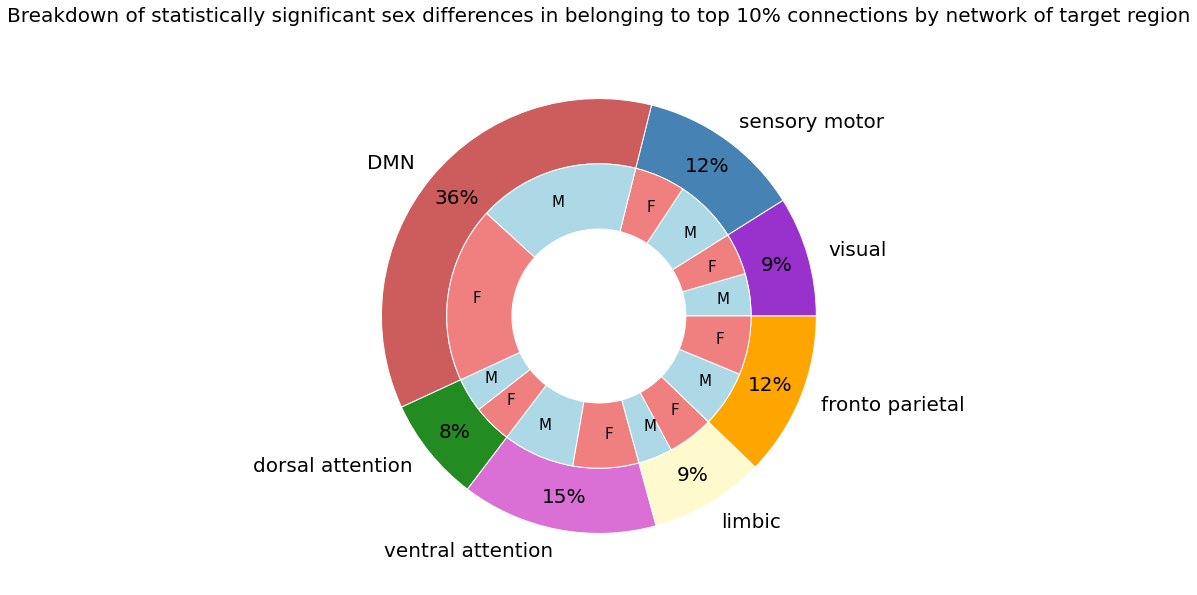

Number of significant parcels by sex:
visual - Male: 90, Female: 89
sensory motor - Male: 136, Female: 108
DMN - Male: 343, Female: 374
dorsal attention - Male: 73, Female: 83
ventral attention - Male: 152, Female: 140
limbic - Male: 73, Female: 98
fronto parietal - Male: 120, Female: 125





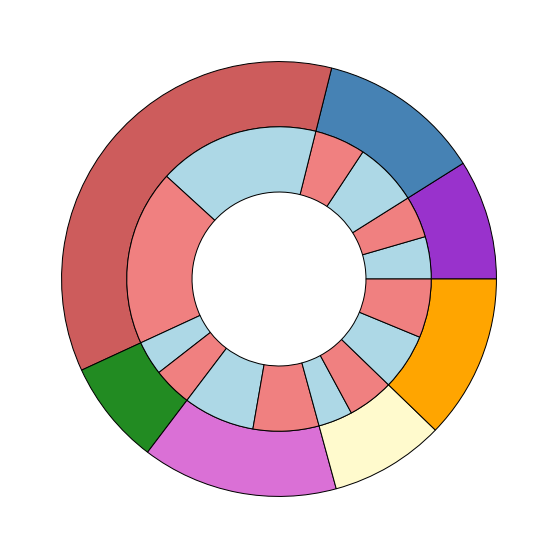

In [110]:
count_sig = 0
count_sig_M = 0
count_sig_F = 0
count_sig_per_network = {"visual": 0, "sensory motor": 0, "DMN": 0, "dorsal attention": 0, "ventral attention": 0, "limbic": 0, "fronto parietal": 0}
count_sig_per_network_bysex = {"visual": [0,0], "sensory motor": [0,0], "DMN": [0,0], "dorsal attention": [0,0], "ventral attention": [0,0], "limbic": [0,0], "fronto parietal": [0,0]} # M: [0], F: [1]

# iterate over rows (seed regions)
for i in range(400):
    
    # iterate over columns (target regions)
    for j in range(400):
    
        if chisquare_qval_matrix[i][j] < 0.05:
            count_sig += 1
            count_sig_per_network[yeo7_networks_array_labels[j]] += 1  # network of seed region

            # positive OR means male odds > female odds: increment the first item of the list for given label
            if OR_matrix[i][j] > 1:
                count_sig_M += 1
                count_sig_per_network_bysex[yeo7_networks_array_labels[j]][0] += 1  # network of seed region

            # negative OR means female odds > male odds: increment the second item of the list for the given label
            else:
                count_sig_F += 1
                count_sig_per_network_bysex[yeo7_networks_array_labels[j]][1] += 1  # network of seed region
           
                
print(f"Number of significant sex differences in odds of connection being in top 10% connections per seed (out of 400x400 -> 160000 connections): {count_sig}\n")
print(f"Number of significant sex differences where odds of connection being in top 10% is male > female (OR > 1): {count_sig_M}")
print(f"Number of significant sex differences where odds of connection being in top 10% is female > male (OR < 1): {count_sig_F}\n")
print("Number of significant sex differences in each Yeo network of the target region (across sexes):")

# using ANSI escape sequences to underline -> bold: \033[1m ; underline: \033[4m ; end: \033[0m
for i in range(len(count_sig_per_network)):
    print(f"- {list(count_sig_per_network.keys())[i]}: \033[1m{round(count_sig_per_network[list(count_sig_per_network.keys())[i]]*100/count_sig,2)}%\033[0m of overall significance")

print("\n\n")




### Nested pie chart

## make data plottable
list_count_sig_per_network_bysex = []

for label in count_sig_per_network_bysex:
    list_count_sig_per_network_bysex.append(count_sig_per_network_bysex[label])

vals = np.array(list_count_sig_per_network_bysex)

outer_colors = ["darkorchid",  # visual
                "steelblue",  # sensorimotor
                "indianred",  # dmn
                "forestgreen",  # dorsal attention
                "orchid",  # ventral attention
                "lemonchiffon",  # limbic
                "orange"]  # frontoparietal



inner_color_plus = 'lightblue'
inner_color_minus = 'lightcoral'



inner_colors = [inner_color_plus, inner_color_minus,  # visual
                inner_color_plus, inner_color_minus,  # sensorimotor
                inner_color_plus, inner_color_minus,  # dmn
                inner_color_plus, inner_color_minus,  # dorsal attention
                inner_color_plus, inner_color_minus,  # ventral attention
                inner_color_plus, inner_color_minus,  # limbic
                inner_color_plus, inner_color_minus]  #frontoparietal

fig, ax = plt.subplots(figsize=(15, 10))

size = 0.3

## plot outer pie
ax.pie(vals.sum(axis=1), radius=1, labels=count_sig_per_network_bysex.keys(), colors=outer_colors, autopct='%.0f%%', pctdistance=0.85,
       wedgeprops=dict(width=size, edgecolor='white'),  textprops={'fontsize': 20})

## plot inner pie

# make a list (in order) containing the labels (sex - hardcoded) only for sections that have more than 1 count (otherwise label is placeholder: blank)

labels_only_show_non_null = []

for network in list_count_sig_per_network_bysex:

    # males
    if network[0] > 0:
        labels_only_show_non_null.append('M')
    else:
        labels_only_show_non_null.append('')

    # females
    if network[1] > 0:
        labels_only_show_non_null.append('F')
    else:
        labels_only_show_non_null.append('')

ax.pie(vals.flatten(), radius=1-size, labels=labels_only_show_non_null, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='white'),  textprops={'fontsize': 15},  labeldistance=0.78)

ax.set(aspect="equal")
ax.set_title(f'Breakdown of statistically significant sex differences in belonging to top 10% connections by network of target region', y=1.03, fontsize=20)

plt.show()

print('Number of significant parcels by sex:')
for network in count_sig_per_network_bysex:
    print(f"{network} - Male: {count_sig_per_network_bysex[network][0]}, Female: {count_sig_per_network_bysex[network][1]}")

print("\n\n")



### plot outer and inner pie (without labels)

fig, disp = plt.subplots(figsize=(15, 10))
size = 0.3

disp.pie(vals.sum(axis=1), radius=1, colors=outer_colors, pctdistance=0.85,
       wedgeprops=dict(width=size, edgecolor='black'),  textprops={'fontsize': 20})

disp.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='blacK'),  textprops={'fontsize': 15},  labeldistance=0.78)

disp.set(aspect="equal")

plt.show()


## save figure in directory 
fig.savefig(resdir_fig+'HCP_connectivity_profile_pie_chart_sex_diff_target_netw.png', dpi=300)
'HCP_connectivity_profile_pie_chart_sex_diff_seed_netw.png'

print("\n\n")

# Mean connectivity profiles (across subjects and per sex)

## Identify the areas that most frequently come up as top 10% connection (for each seed) -> Top indices

This has been computed by p1_connectivity_profiles_mean_profiles.py

### Adding up the binary matrices across subjects to get "counts" matrices (across all subjects, males and females)

### Identifying the top 10% indices (across all subjects, males and females)

## Compute the geodesic distances of the mean connectivity profiles 
(i.e., for each seed region, the connections with areas that recur most frequently) across all subjects, across males, and across females

This has been computed by p1_connectivity_profiles_mean_profiles.py

## Visualize mean connectivity profiles 

### Load output from p1_connectivity_profiles_mean_profiles.py

In [127]:
# geodesic distances for top connections
scipy.io.whosmat(resdir_hcp+'connectivity_profiles_geodesic_distances.mat')

[('geodesic_distances_most_frequent_connections', (1000, 400, 20), 'double'),
 ('mean_geodesic_distances_most_frequent_connections', (1000, 400), 'double'),
 ('most_frequent_connections_indices', (400, 20), 'int64'),
 ('geodesic_distances_most_frequent_connections_M', (464, 400, 20), 'double'),
 ('mean_geodesic_distances_most_frequent_connections_M', (464, 400), 'double'),
 ('most_frequent_connections_indices_M', (400, 20), 'int64'),
 ('geodesic_distances_most_frequent_connections_F', (536, 400, 20), 'double'),
 ('mean_geodesic_distances_most_frequent_connections_F', (536, 400), 'double'),
 ('most_frequent_connections_indices_F', (400, 20), 'int64')]

In [28]:
# taking the list of subjects that have fc data
geodesic_distances_most_frequent_connections = scipy.io.loadmat(resdir_hcp+'connectivity_profiles_geodesic_distances.mat')['geodesic_distances_most_frequent_connections']
geodesic_distances_most_frequent_connections_M = scipy.io.loadmat(resdir_hcp+'connectivity_profiles_geodesic_distances.mat')['geodesic_distances_most_frequent_connections_M']
geodesic_distances_most_frequent_connections_F = scipy.io.loadmat(resdir_hcp+'connectivity_profiles_geodesic_distances.mat')['geodesic_distances_most_frequent_connections_F']

# indices of most frequent connections
most_frequent_connections_indices = scipy.io.loadmat(resdir_hcp+'connectivity_profiles_geodesic_distances.mat')['most_frequent_connections_indices']
most_frequent_connections_indices_M = scipy.io.loadmat(resdir_hcp+'connectivity_profiles_geodesic_distances.mat')['most_frequent_connections_indices_M']
most_frequent_connections_indices_F = scipy.io.loadmat(resdir_hcp+'connectivity_profiles_geodesic_distances.mat')['most_frequent_connections_indices_F']

In [162]:
geodesic_distances_most_frequent_connections.shape

(1000, 400, 20)

### Chord plots

#### Calculate mean geodesic distances across subjects of each top 10% connection for every seed region -> matrix size 400x20
NOT TO BE CONFUSED with mean_geodesic_distances_most_frequent_connections from mat file which is mean WIHTIN subjects of geodesic distance of top 10% for each seed region -> 400 values in total
here we compute mean ACROSS subjects for each top connection between seed and top 10% connection value -> 8000 values in total


In [163]:
group_mean_geodesic_distances_most_frequent_connections = np.mean(geodesic_distances_most_frequent_connections, axis=0)
group_mean_geodesic_distances_most_frequent_connections_M = np.mean(geodesic_distances_most_frequent_connections_M, axis=0)
group_mean_geodesic_distances_most_frequent_connections_F = np.mean(geodesic_distances_most_frequent_connections_F, axis=0)

#### Arrange data in shape for Chord plot (df with source, target and weight columns)

In [164]:
dict_most_frequent_connections_by_network = {'source': [], 'target': [], 'weight': []}

# iterate over seed regions
for i in range(len(group_mean_geodesic_distances_most_frequent_connections)):
    
    # iterate over 20 (top 10%) connections
    for j in range(len(group_mean_geodesic_distances_most_frequent_connections[0])):

        # append to dictionary by network
        dict_most_frequent_connections_by_network['source'].append(yeo7_networks_array_labels[i])
        dict_most_frequent_connections_by_network['target'].append(yeo7_networks_array_labels[most_frequent_connections_indices[i][j]])  # take the value of the index that j corresponds to to retrieve yeo network of target
        dict_most_frequent_connections_by_network['weight'].append(group_mean_geodesic_distances_most_frequent_connections[i][j])  # take the mean geodesic distance across subjects as weight for this connection
            
df_most_frequent_connections_by_network = pd.DataFrame(dict_most_frequent_connections_by_network)

In [165]:
dict_most_frequent_connections_by_network_M = {'source': [], 'target': [], 'weight': []}

# iterate over seed regions
for i in range(len(group_mean_geodesic_distances_most_frequent_connections_M)):
    
    # iterate over 20 (top 10%) connections
    for j in range(len(group_mean_geodesic_distances_most_frequent_connections_M[0])):

        # append to dictionary by network
        dict_most_frequent_connections_by_network_M['source'].append(yeo7_networks_array_labels[i])
        dict_most_frequent_connections_by_network_M['target'].append(yeo7_networks_array_labels[most_frequent_connections_indices_M[i][j]])  # take the value of the index that j corresponds to to retrieve yeo network of target
        dict_most_frequent_connections_by_network_M['weight'].append(group_mean_geodesic_distances_most_frequent_connections_M[i][j])  # take the mean geodesic distance across subjects as weight for this connection
            
df_most_frequent_connections_by_network_M = pd.DataFrame(dict_most_frequent_connections_by_network_M)

In [166]:
dict_most_frequent_connections_by_network_F = {'source': [], 'target': [], 'weight': []}

# iterate over seed regions
for i in range(len(group_mean_geodesic_distances_most_frequent_connections_F)):
    
    # iterate over 20 (top 10%) connections
    for j in range(len(group_mean_geodesic_distances_most_frequent_connections_F[0])):

        # append to dictionary by network
        dict_most_frequent_connections_by_network_F['source'].append(yeo7_networks_array_labels[i])
        dict_most_frequent_connections_by_network_F['target'].append(yeo7_networks_array_labels[most_frequent_connections_indices_F[i][j]])  # take the value of the index that j corresponds to to retrieve yeo network of target
        dict_most_frequent_connections_by_network_F['weight'].append(group_mean_geodesic_distances_most_frequent_connections_F[i][j])  # take the mean geodesic distance across subjects as weight for this connection
            
df_most_frequent_connections_by_network_F = pd.DataFrame(dict_most_frequent_connections_by_network_F)

In [158]:
df_most_frequent_connections_by_network_F

,source,target,weight
0,visual,visual,24.899037
1,visual,visual,46.023242
2,visual,dorsal attention,33.843402
3,visual,visual,88.031894
4,visual,visual,110.325014
...,...,...,...
7995,DMN,ventral attention,18.485847
7996,DMN,DMN,33.095944
7997,DMN,DMN,117.174586
7998,DMN,dorsal attention,132.020370


#### Plot

In [149]:
# Load d3blocks
from d3blocks import D3Blocks

# Initialize
d3 = D3Blocks()

[d3blocks] >INFO> Cleaning edge_properties and config parameters..


In [150]:
d3.chord(df_most_frequent_connections_by_network)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> Create directory: [/tmp/d3blocks]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html


In [180]:
d3.chord(df_most_frequent_connections_by_network_M)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html


In [181]:
d3.chord(df_most_frequent_connections_by_network_F)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html


#### Troubleshooting why Chord plots look the same

Where there are different areas involved, they belong to the same networks? -> kind of... but not exactly

In [219]:
# find the non-overlap of connections between male and female most frequent connections

non_overlap_sexes_indices_frequent_connections = {'indices' : [], 'yeo networks': []}

for i in range(len(most_frequent_connections_indices_M)):
    
    # non overlapping indices
    temp_indices = set(most_frequent_connections_indices_M[i]).symmetric_difference(set(most_frequent_connections_indices_F[i]))
    
    # their corresponding yeo networks
    temp_yeo = yeo7_networks_array_labels[list(temp_indices)]
    
    # append to dictionary
    non_overlap_sexes_indices_frequent_connections['indices'].append(list(temp_indices))
    non_overlap_sexes_indices_frequent_connections['yeo networks'].append(temp_yeo.tolist())
    
    

In [221]:
df_non_overlap_sexes_indices_frequent_connections = pd.DataFrame(non_overlap_sexes_indices_frequent_connections)
df_non_overlap_sexes_indices_frequent_connections

,indices,yeo networks
0,"[1, 8]","[visual, visual]"
1,"[71, 139, 19, 22, 151, 88, 163, 175, 183, 189]","[dorsal attention, fronto parietal, visual, vi..."
2,"[72, 25]","[dorsal attention, visual]"
3,[],[]
4,"[81, 27]","[dorsal attention, visual]"
...,...,...
395,"[384, 370]","[DMN, DMN]"
396,"[337, 348, 364, 367, 379, 382]","[fronto parietal, fronto parietal, DMN, DMN, D..."
397,"[385, 332]","[DMN, fronto parietal]"
398,"[388, 342]","[DMN, fronto parietal]"


In [225]:
df_non_overlap_sexes_indices_frequent_connections['num_sig_q_vals_per_area'] = num_sig_q_vals_per_area
pd.set_option("max_rows", None)
df_non_overlap_sexes_indices_frequent_connections

,indices,yeo networks,num_sig_q_vals_per_area
0,"[1, 8]","[visual, visual]",0.0
1,"[71, 139, 19, 22, 151, 88, 163, 175, 183, 189]","[dorsal attention, fronto parietal, visual, vi...",9.0
2,"[72, 25]","[dorsal attention, visual]",3.0
3,[],[],8.0
4,"[81, 27]","[dorsal attention, visual]",6.0
5,"[72, 27]","[dorsal attention, visual]",0.0
6,"[19, 26, 28, 180]","[visual, visual, visual, DMN]",2.0
7,"[70, 77]","[dorsal attention, dorsal attention]",14.0
8,[],[],0.0
9,"[5, 7]","[visual, visual]",1.0


### Nichord

In [57]:
import numpy as np
from nilearn import plotting

In [62]:
from nilearn import datasets

msdl_atlas_dataset = datasets.fetch_atlas_msdl()
rest_dataset = datasets.fetch_development_fmri(n_subjects=1)

# print basic information on the dataset
print(
    f"First subject functional nifti image (4D) is at: {rest_dataset.func[0]}"
)

First subject functional nifti image (4D) is at: /data/hu_serio/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [64]:
atlas_img = msdl_atlas_dataset.maps
atlas_region_coords = plotting.find_probabilistic_atlas_cut_coords(atlas_img)
labels = msdl_atlas_dataset.labels

In [59]:
fc_matrices.shape

(1000, 400, 400)

ValueError: Shape mismatch between 'adjacency_matrix' and 'node_coords''adjacency_matrix' shape is (400, 400), 'node_coords' shape is (39, 3)

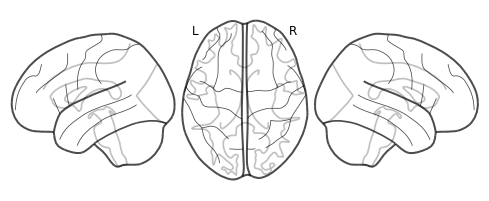

In [69]:
plotting.plot_connectome(
    fc_matrices[0],
    atlas_region_coords,
    edge_threshold="90%",
    title="",
    display_mode="lzr",
)

In [66]:
atlas_img

'/data/hu_serio/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii'

In [68]:
atlas_region_coords.shape

(39, 3)

In [70]:
atlas_region_coords

array([[-5.40853286e+01, -8.53834903e+00,  3.22882923e+01],
       [ 5.58909704e+01, -5.43509864e+00,  3.08030049e+01],
       [-2.02793024e-02, -7.57016911e+01,  1.11198293e+01],
       [-4.69119937e+01, -6.50009513e+01,  3.12207984e+01],
       [-3.74879842e-01, -5.60553281e+01,  2.94370727e+01],
       [ 6.43985564e-02,  5.31195303e+01,  7.30926308e+00],
       [ 5.38443059e+01, -5.89423060e+01,  2.75001946e+01],
       [ 1.58142884e+00, -9.31860506e+01, -1.18797775e+00],
       [ 2.27324772e-01, -2.16802734e+01,  6.07733206e+01],
       [ 4.43336133e+01,  2.14547003e+01,  4.24303364e+01],
       [ 3.90094367e+01,  5.58543910e+01,  5.80086201e-01],
       [ 4.95039238e+01, -5.26164827e+01,  4.58620564e+01],
       [ 6.32379634e+01, -3.34023367e+01, -7.98260029e+00],
       [-1.71844319e+01,  5.62819883e+00,  4.91426361e+00],
       [-4.15913945e+01, -6.12767846e+01,  4.74818289e+01],
       [-4.53018163e+01,  1.83291390e+01,  4.01892348e+01],
       [-4.16742508e+01,  5.08690882e+01

In [6]:
import inspect as i
import sys
sys.stdout.write(i.getsource(plotting.plot_connectome))

@fill_doc
def plot_connectome(adjacency_matrix, node_coords,
                    node_color='auto', node_size=50,
                    edge_cmap=cm.bwr,
                    edge_vmin=None, edge_vmax=None,
                    edge_threshold=None,
                    output_file=None, display_mode='ortho',
                    figure=None, axes=None, title=None,
                    annotate=True, black_bg=False,
                    alpha=0.7,
                    edge_kwargs=None, node_kwargs=None,
                    colorbar=False):
    """Plot connectome on top of the brain glass schematics.

    The plotted image should be in MNI space for this function to work
    properly.

    In the case of 'l' and 'r' directions (for hemispheric projections),
    markers in the coordinate x == 0 are included in both hemispheres.

    Parameters
    ----------
    adjacency_matrix : numpy array of shape (n, n)
        Represents the link strengths of the graph. The matrix can be
        symmetric wh

4281

#  Chord plots showing sex differences by network with mean geodesic distance (across subjects) as weighting

In [232]:
# geodesic distances for top connections
scipy.io.whosmat('/data/p_02667/sex_diff_gradients/data/geodesic_distance/geodesic_distances_matrices.mat')

[('geodesic_distances_matrices_corrected', (1000, 400, 400), 'double')]

In [29]:
# loading the full geodesic distance matrices of all subjects
geodesic_distances_matrices = scipy.io.loadmat('/data/p_02667/sex_diff_gradients/data/geodesic_distance/geodesic_distances_matrices.mat')['geodesic_distances_matrices_corrected']

In [44]:
geodesic_distances_matrices.shape

(1000, 400, 400)

#### Calculate means across subjects of each connection for every seed region -> matrix size 400x400
here we compute mean ACROSS subjects for each connection between seed and each of Schaefer's 400 parcels -> 160000 values in total

In [33]:
group_mean_geodesic_distances = np.mean(geodesic_distances_matrices, axis=0)

In [34]:
group_mean_geodesic_distances.shape

(400, 400)

In [94]:
dict_connections_sig_sex_diff_by_network = {'source': [], 'target': [], 'weight': []}
OR_sig_sex_diff = []

for i in range(400):
    
    for j in range(400):
        
        # for connection nodes showing significant sex differences
        if chisquare_qval_matrix[i][j] <= 0.05:
            
            # append to dictionary by network
            dict_connections_sig_sex_diff_by_network['source'].append(yeo7_networks_array_labels[i])
            dict_connections_sig_sex_diff_by_network['target'].append(yeo7_networks_array_labels[j])
            dict_connections_sig_sex_diff_by_network['weight'].append(group_mean_geodesic_distances[i][j])  # take the mean geodesic distance across subjects as weight for this connection
            
            # also keep track of OR for connections that show significant sex differences
            OR_sig_sex_diff.append(OR_matrix[i][j]) 
            
            
df_connections_sig_sex_diff_by_network = pd.DataFrame(dict_connections_sig_sex_diff_by_network)

In [243]:
d3.chord(df_connections_sig_sex_diff_by_network)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html


# Histograms by OR (direction of effects) of frequency of statistically significant sex differences (in odds of being in top 10% of seed's connections) by geodesic distance
- OR > 1 → males greater odds of connection to seed belonging to top 10% of connections
- OR < 1 → females greater odds of connection to seed belonging to top 10% of connections

In [35]:
# creating dictionary splitting significant results with OR > 1 (male greater odds of having connection as top 10%) vs OR < 1 (females greater odds of having connection as top 10%)
# as well as geodesic distance of connnection, seed network and target netwokr
OR_above_1 = {'OR': [], 'geodesic distance': [], 'seed network': [], 'target network': []}
OR_below_1 = {'OR': [], 'geodesic distance': [], 'seed network': [], 'target network': []}


# iterate over rows (seed regions)
for i in range(400):
    
    # iterate over columns (target regions)
    for j in range(400):
    
        if chisquare_qval_matrix[i][j] < 0.05:
            
            if OR_matrix[i][j] > 1:
                OR_above_1['OR'].append(OR_matrix[i][j])
                OR_above_1['geodesic distance'].append(group_mean_geodesic_distances[i][j])  # take the mean geodesic distance across subjects as weight for this connection
                OR_above_1['seed network'].append(yeo7_networks_array_labels[i])  # take the yeo network label for the seed region
                OR_above_1['target network'].append(yeo7_networks_array_labels[j])  # take the yeo network label for the target region

            else:
                OR_below_1['OR'].append(OR_matrix[i][j])
                OR_below_1['geodesic distance'].append(group_mean_geodesic_distances[i][j])  # take the mean geodesic distance across subjects as weight for this connection
                OR_below_1['seed network'].append(yeo7_networks_array_labels[i])  # take the yeo network label for the seed region
                OR_below_1['target network'].append(yeo7_networks_array_labels[j])  # take the yeo network label for the target region
                
                
df_OR_above_1 = pd.DataFrame(OR_above_1)
df_OR_below_1 = pd.DataFrame(OR_below_1)

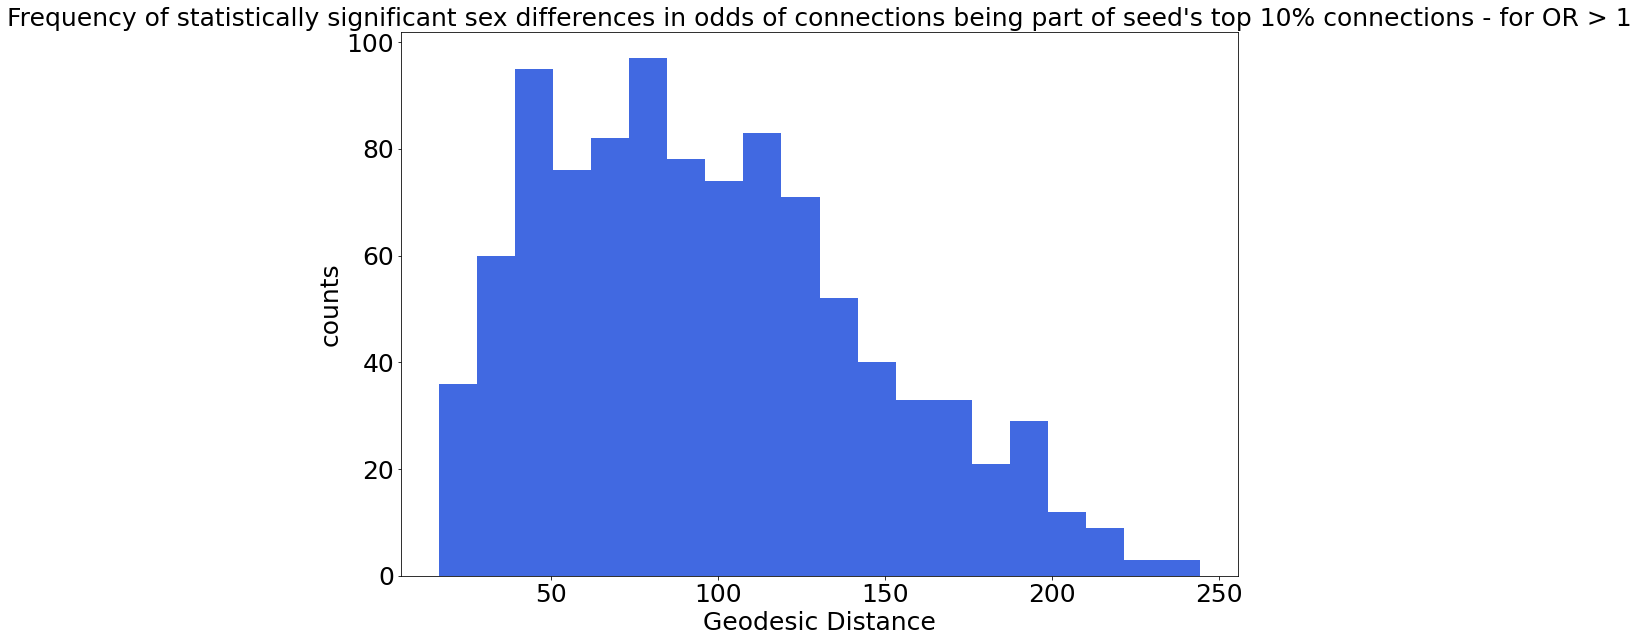

In [40]:
fig, ax = plt.subplots(figsize=(15,10));

plt.hist(OR_above_1['geodesic distance'], bins=20, color='royalblue')

ax.set_title("Frequency of statistically significant sex differences in odds of connections being part of seed's top 10% connections - for OR > 1", fontsize=25)
ax.set_xlabel('Geodesic Distance', fontsize=25);
ax.set_ylabel('counts', fontsize=25);
ax.tick_params(labelsize=25);

plt.show()

networks of seed regions


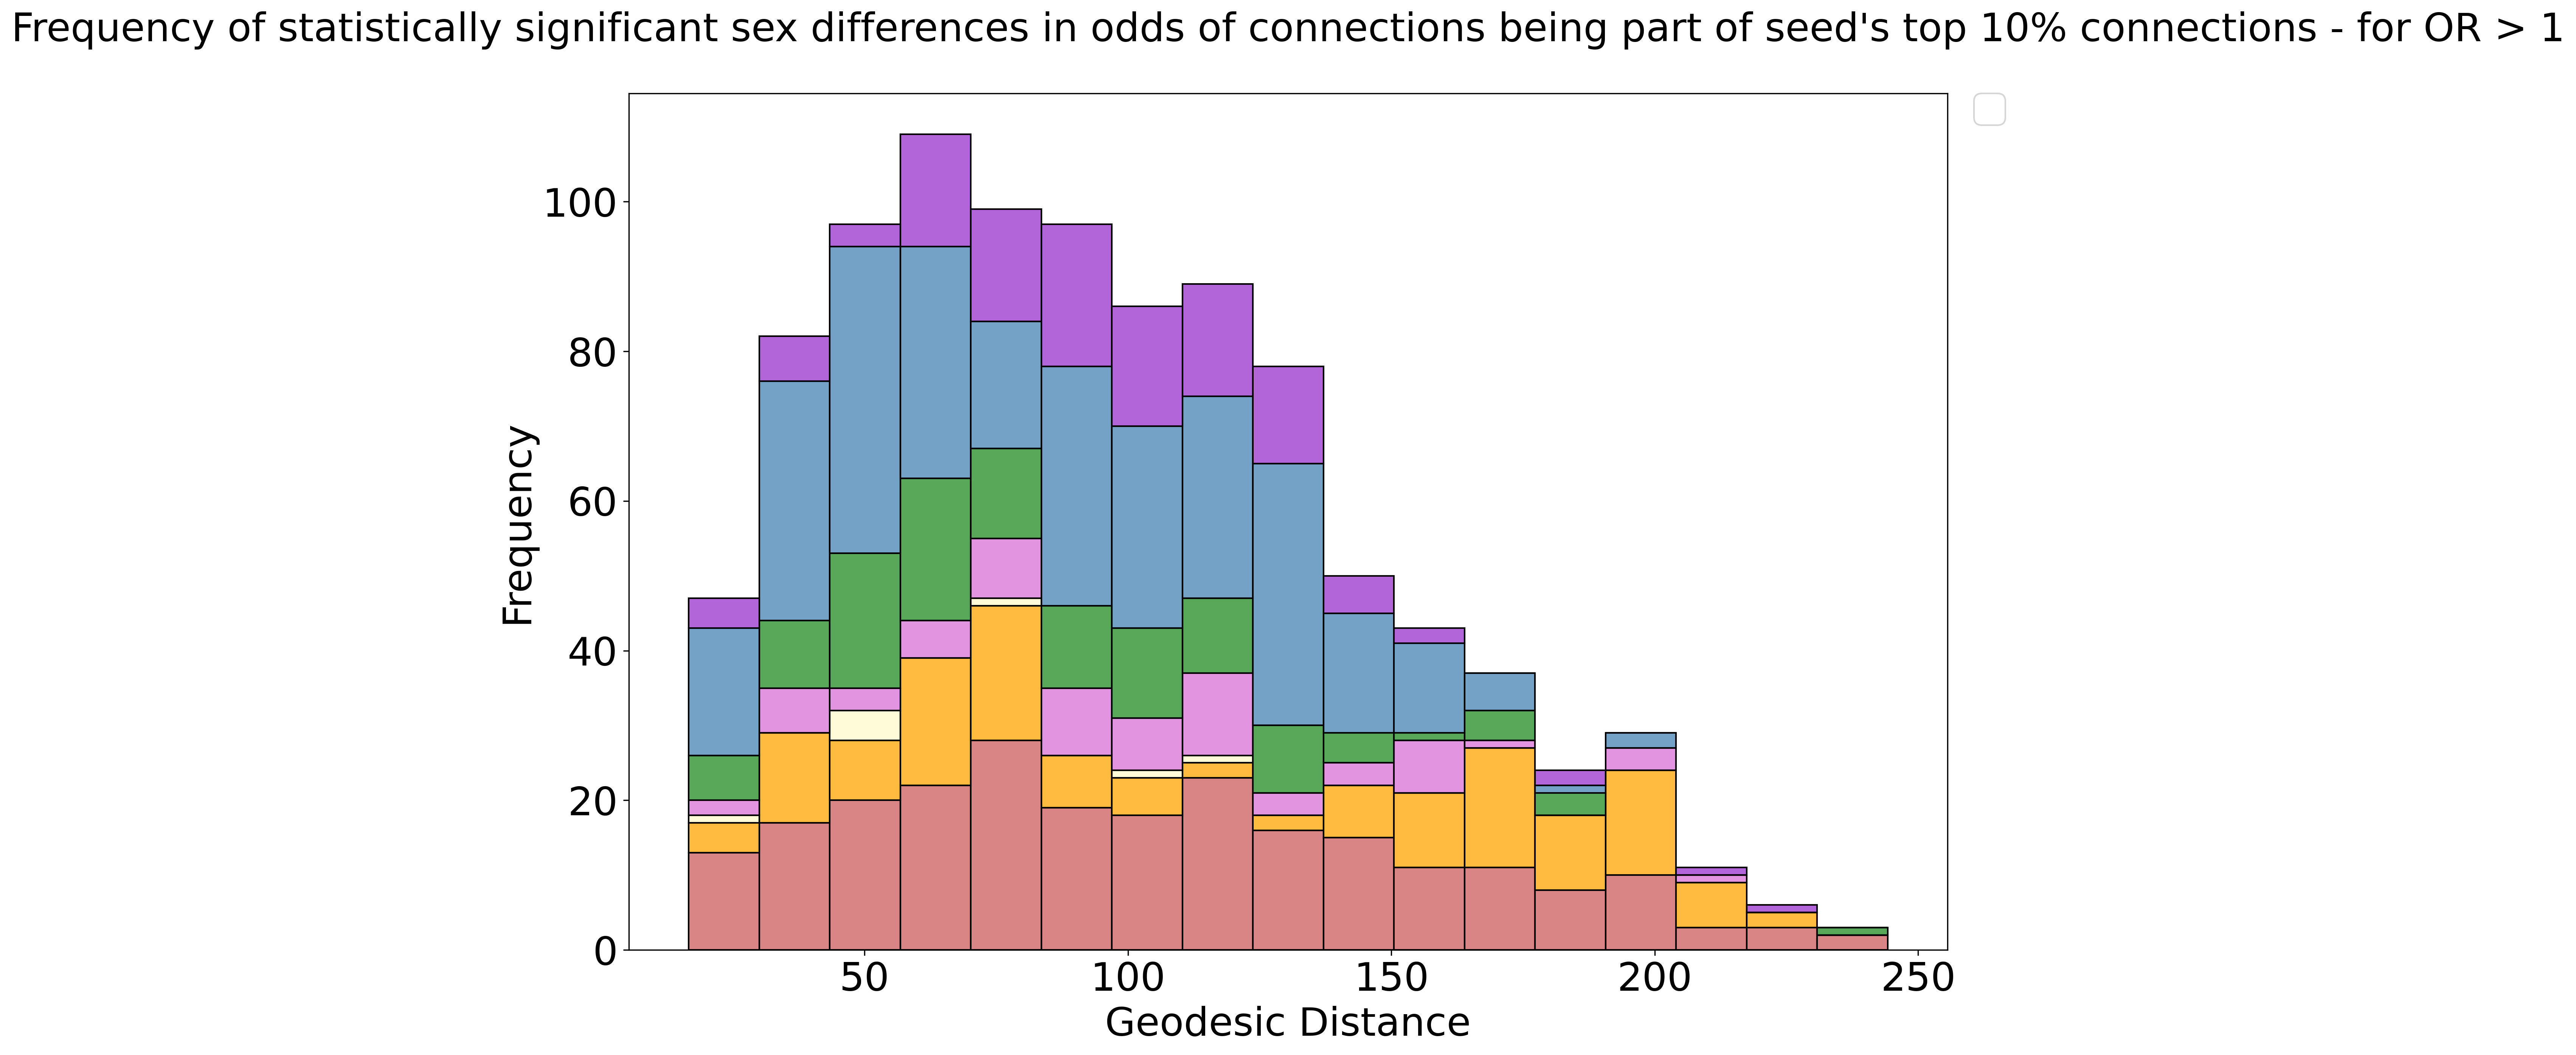

In [55]:
print("networks of seed regions")

plt.figure(figsize=(15, 10), dpi=300)

sns.histplot(data=df_OR_above_1, 
             x="geodesic distance", 
             hue="seed network", 
             multiple="stack",
             legend = True,
             palette=palette_labeled_networks)

plt.title(f"Frequency of statistically significant sex differences in odds of connections being part of seed's top 10% connections - for OR > 1", y=1.05, fontsize=25)
plt.xlabel('Geodesic Distance', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.tick_params(labelsize=25)

# Create a legend outside the plot
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, fontsize=25, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig(resdir_fig+'HCP_hist_connectivity_profile_freq_sex_diff_geo_seed_network_OR_above_1.png', dpi=300, bbox_inches="tight")  # bbox_inches is so that the figure doesn't get cut off when saving

networks of target regions


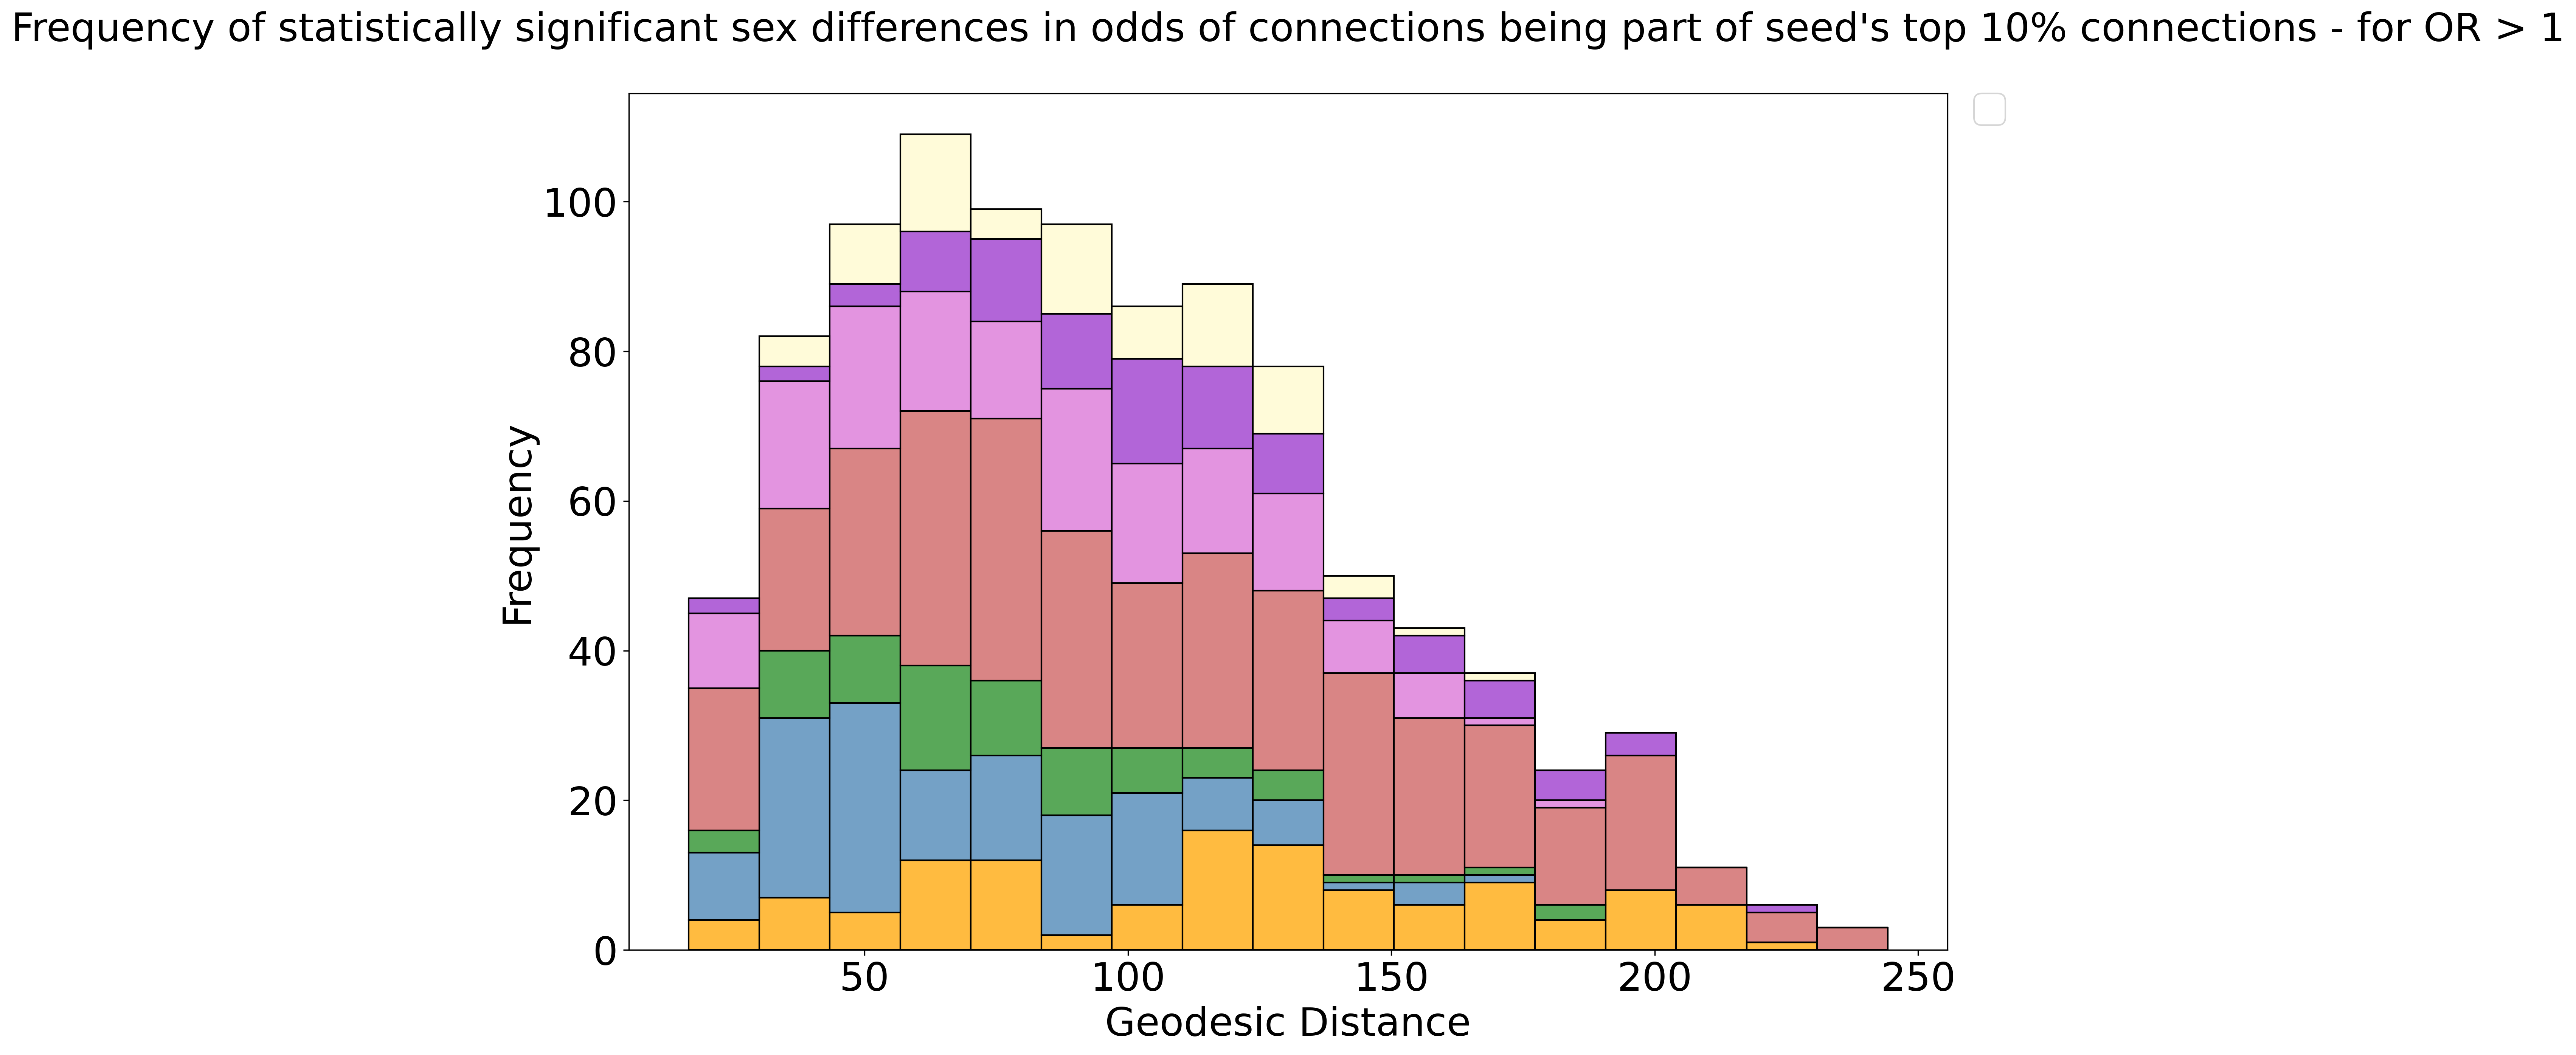

In [56]:
print("networks of target regions")

plt.figure(figsize=(15, 10), dpi=300)

sns.histplot(data=df_OR_above_1, 
             x="geodesic distance", 
             hue="target network", 
             multiple="stack",
             legend = True,
             palette=palette_labeled_networks)

plt.title(f"Frequency of statistically significant sex differences in odds of connections being part of seed's top 10% connections - for OR > 1", y=1.05, fontsize=25)
plt.xlabel('Geodesic Distance', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.tick_params(labelsize=25)

# Create a legend outside the plot
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, fontsize=25, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig(resdir_fig+'HCP_hist_connectivity_profile_freq_sex_diff_geo_target_network_OR_above_1.png', dpi=300, bbox_inches="tight")  # bbox_inches is so that the figure doesn't get cut off when saving

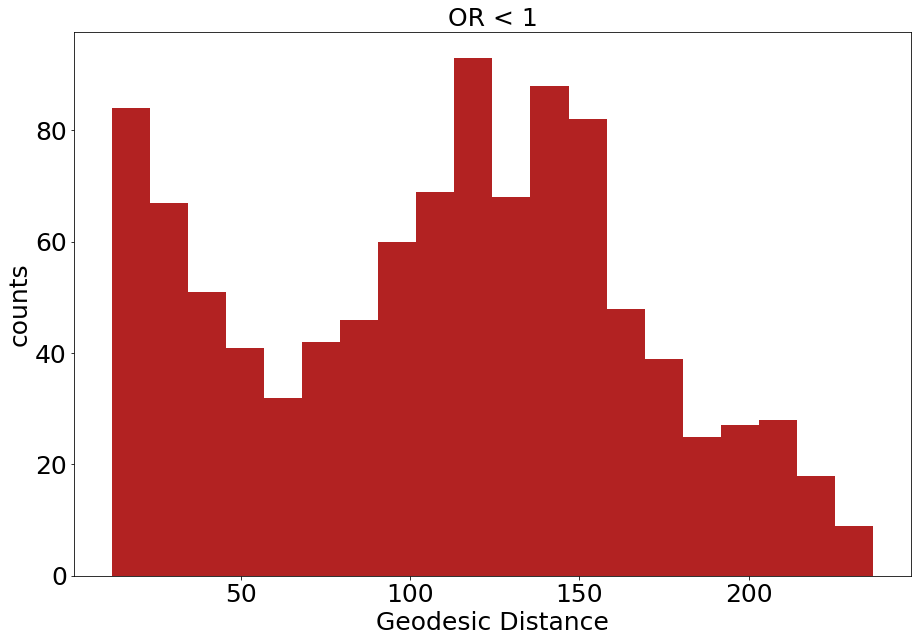

In [108]:
fig, ax = plt.subplots(figsize=(15,10));

plt.hist(OR_below_1['geodesic distance'], bins=20, color='firebrick')

ax.set_xlabel('Geodesic Distance', fontsize=25);
ax.set_ylabel('counts', fontsize=25);
ax.tick_params(labelsize=25);
ax.set_title('OR < 1', fontsize=25)

plt.show()

networks of seed regions


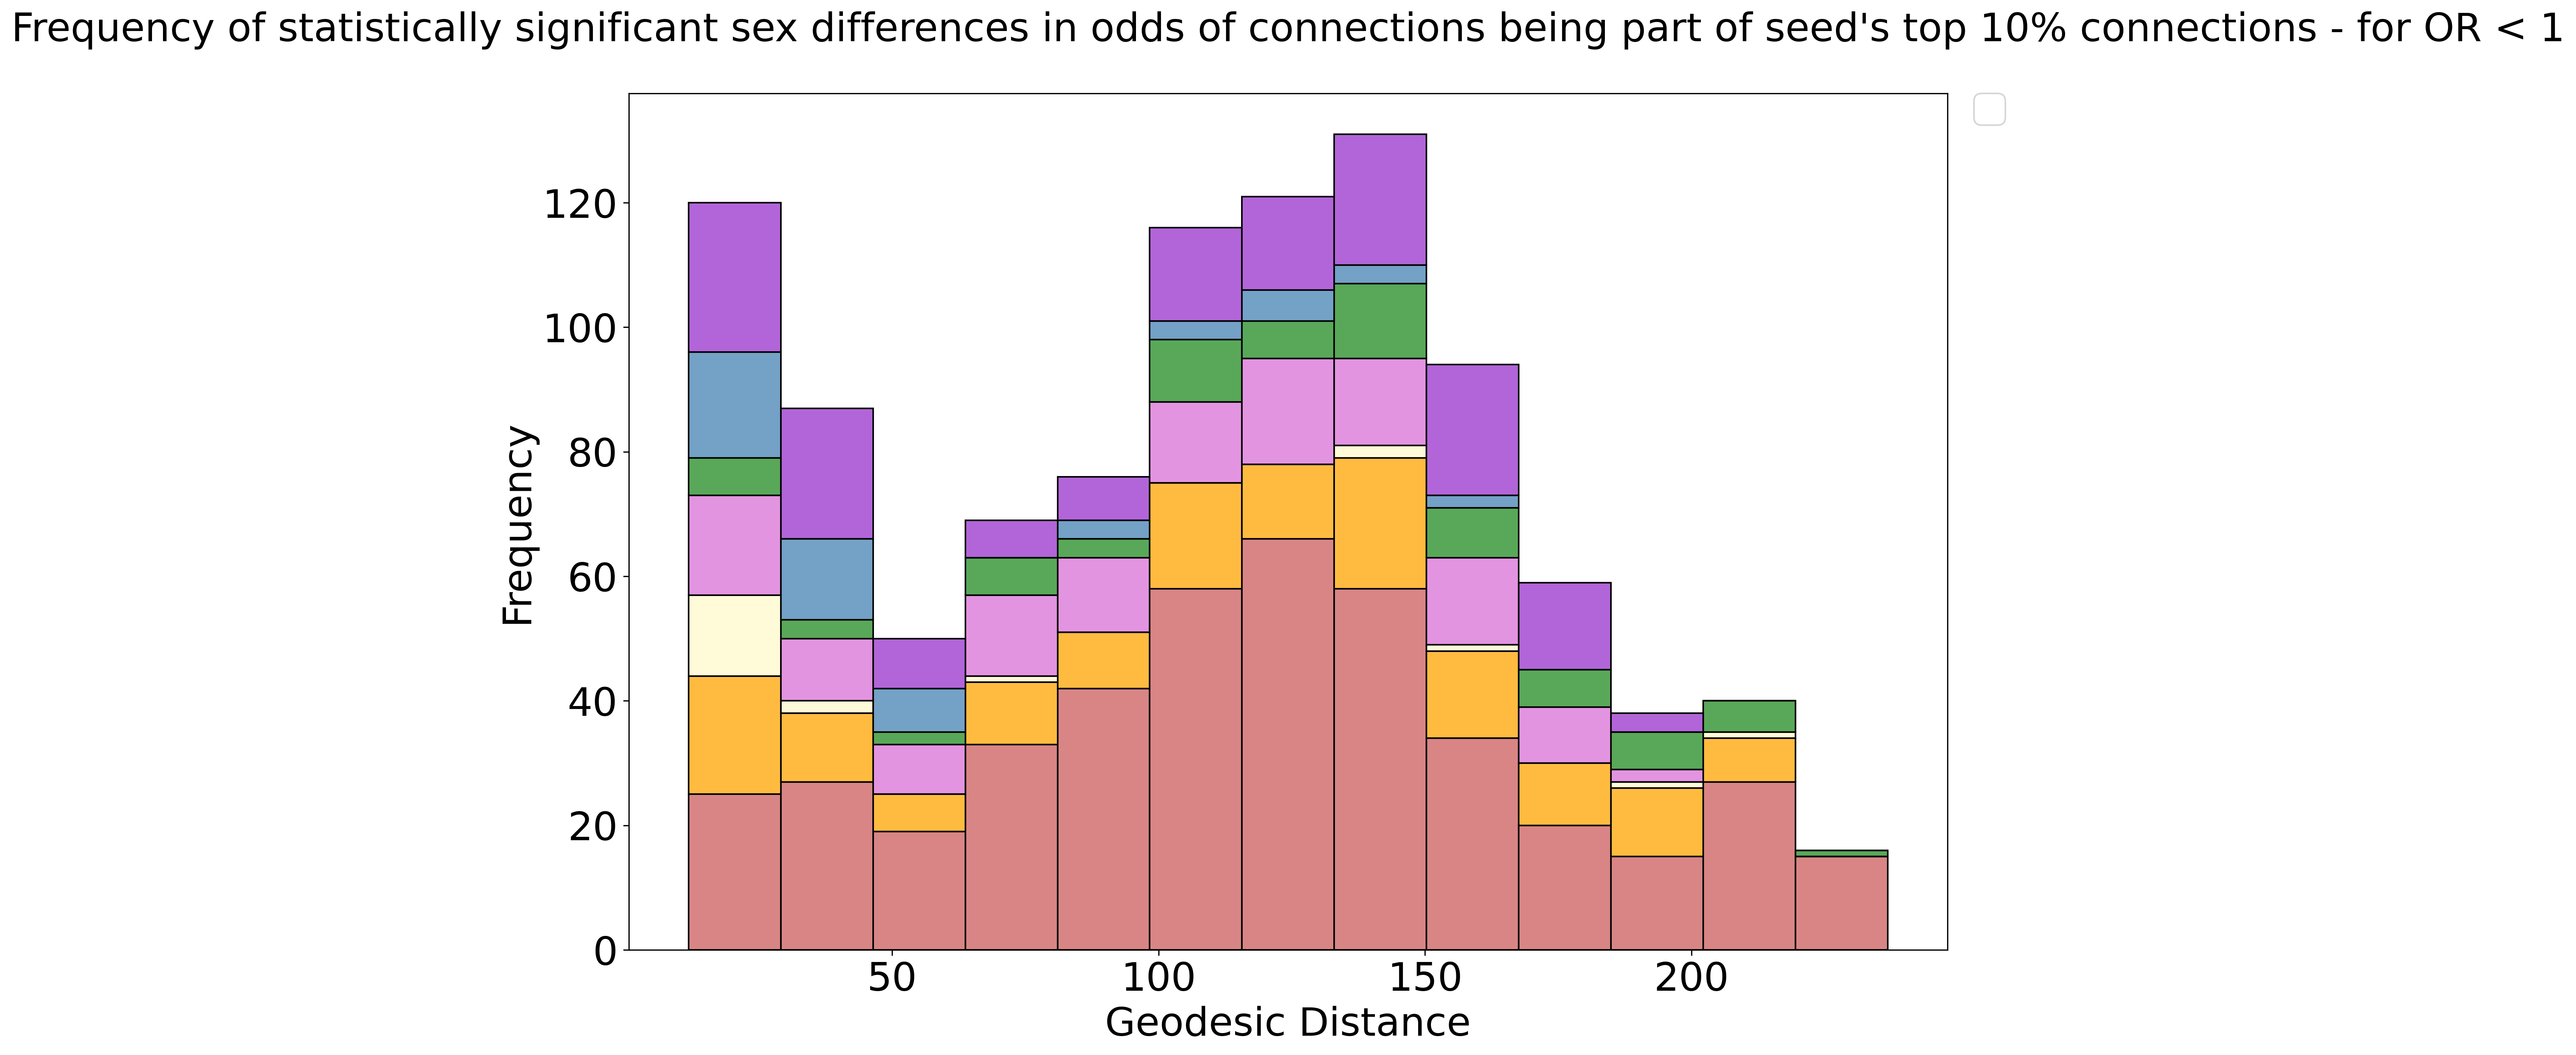

In [57]:
print("networks of seed regions")

plt.figure(figsize=(15, 10), dpi=300)

sns.histplot(data=df_OR_below_1, 
             x="geodesic distance", 
             hue="seed network", 
             multiple="stack",
             legend = True,
             palette=palette_labeled_networks)

plt.title(f"Frequency of statistically significant sex differences in odds of connections being part of seed's top 10% connections - for OR < 1", y=1.05, fontsize=25)
plt.xlabel('Geodesic Distance', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.tick_params(labelsize=25)

# Create a legend outside the plot
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, fontsize=25, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig(resdir_fig+'HCP_hist_connectivity_profile_freq_sex_diff_geo_seed_network_OR_below_1.png', dpi=300, bbox_inches="tight")  # bbox_inches is so that the figure doesn't get cut off when saving

networks of target regions


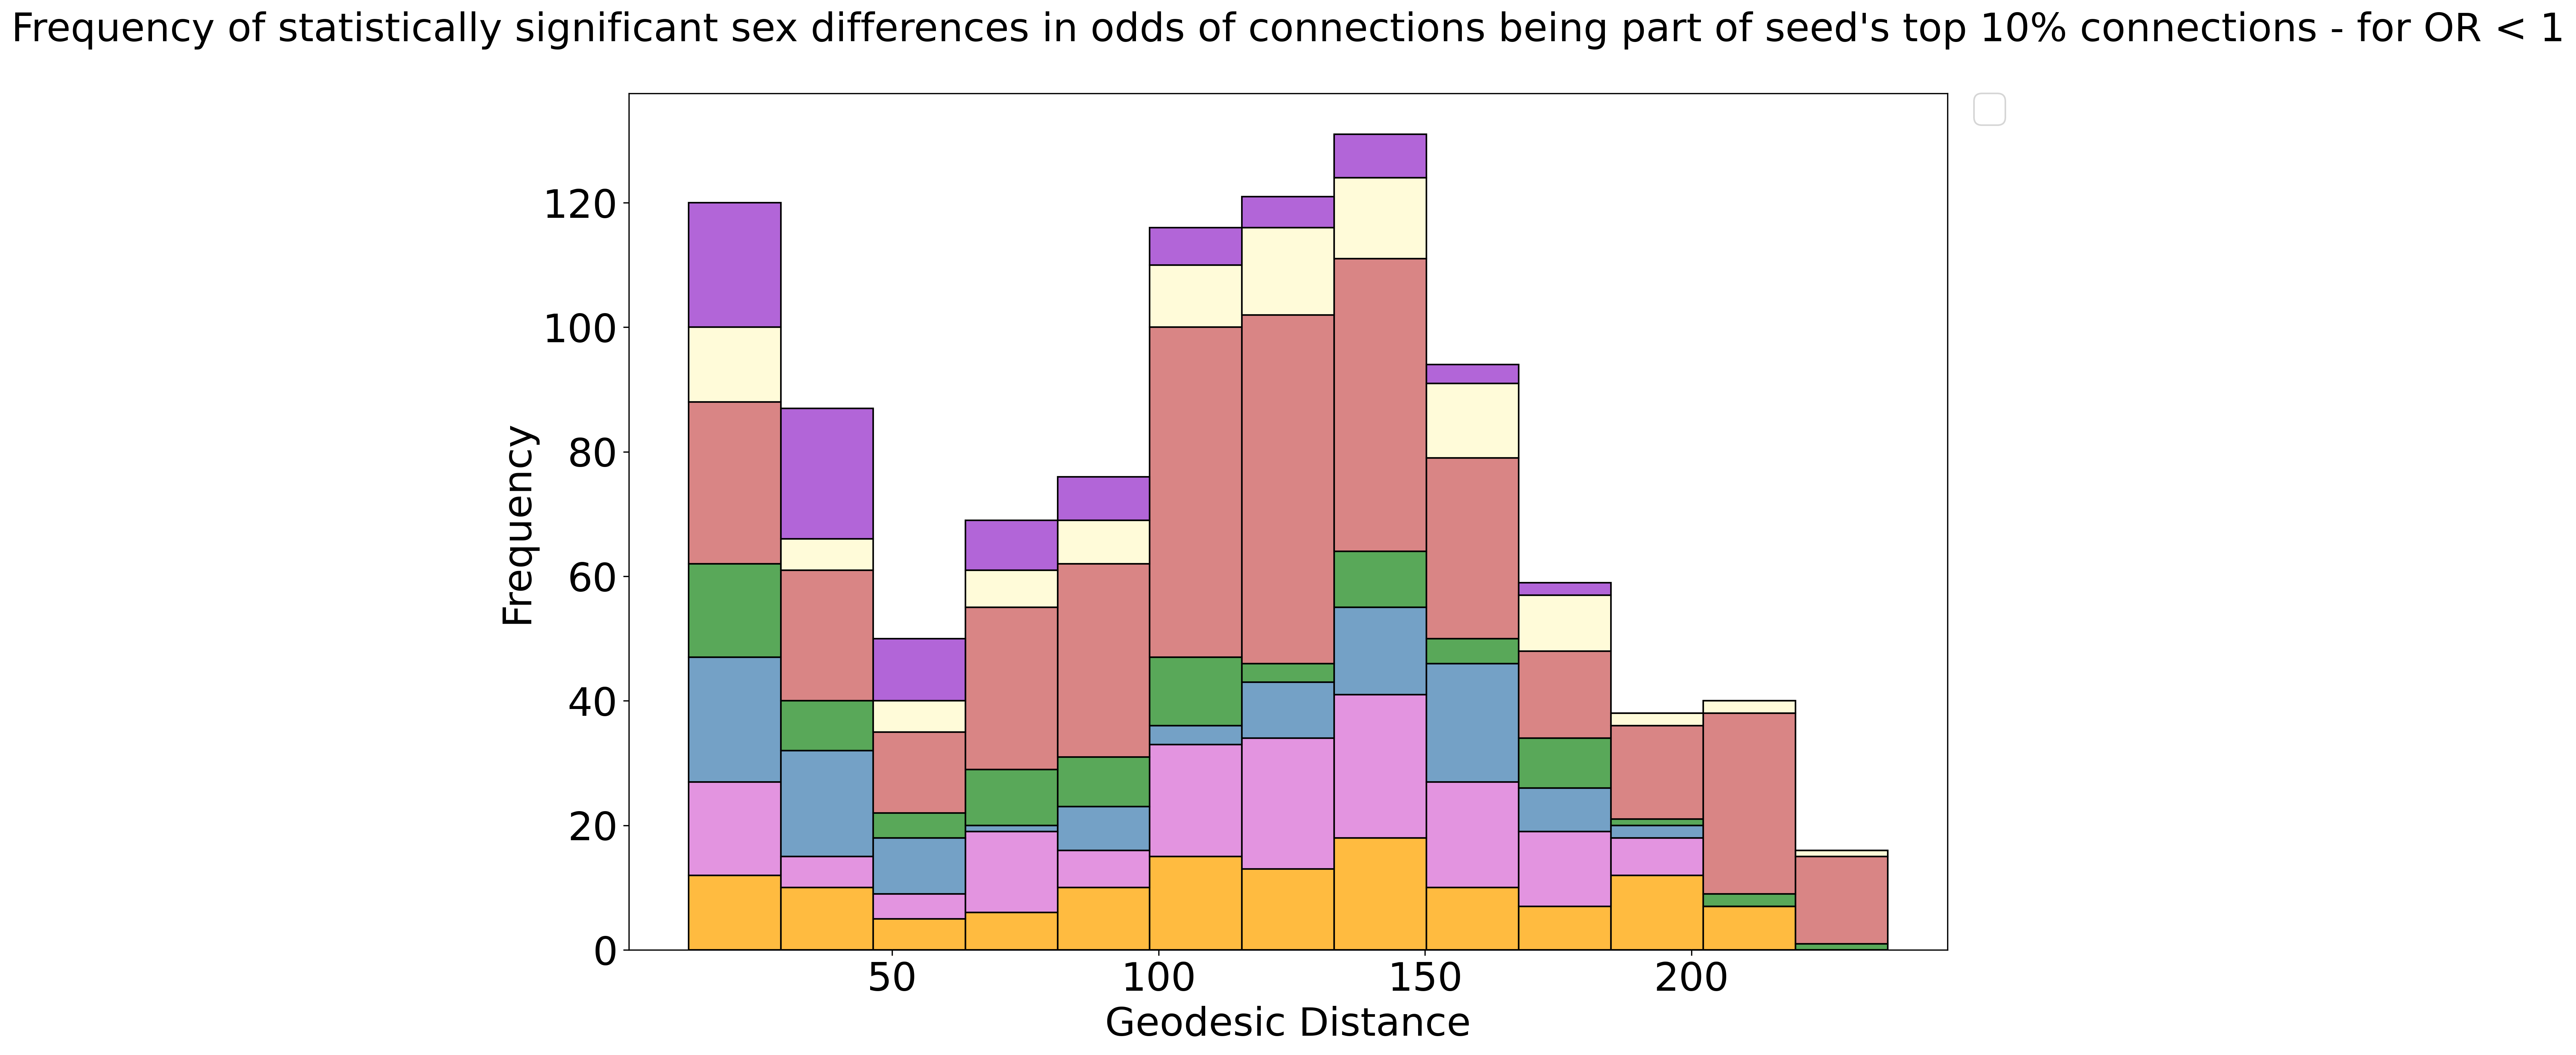

In [58]:
print("networks of target regions")

plt.figure(figsize=(15, 10), dpi=300)

sns.histplot(data=df_OR_below_1, 
             x="geodesic distance", 
             hue="target network", 
             multiple="stack",
             legend = True,
             palette=palette_labeled_networks)

plt.title(f"Frequency of statistically significant sex differences in odds of connections being part of seed's top 10% connections - for OR < 1", y=1.05, fontsize=25)
plt.xlabel('Geodesic Distance', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.tick_params(labelsize=25)

# Create a legend outside the plot
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, fontsize=25, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig(resdir_fig+'HCP_hist_connectivity_profile_freq_sex_diff_geo_target_network_OR_below_1.png', dpi=300, bbox_inches="tight")  # bbox_inches is so that the figure doesn't get cut off when saving

## Histograms by OR (direction of effects) of frequency of effect by effect size (OR)

although misleading to plot this way because because cannot linearly compare OR effect size above and below 1....

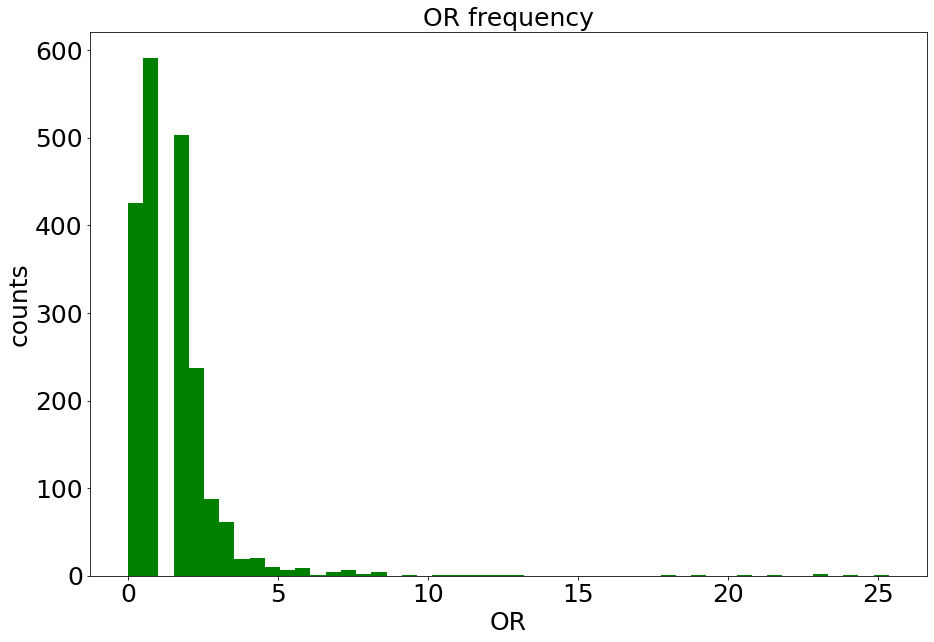

In [56]:
fig, ax = plt.subplots(figsize=(15,10));

plt.hist(OR_sig_sex_diff, bins=50, color='green')

ax.set_xlabel('OR', fontsize=25);
ax.set_ylabel('counts', fontsize=25);
ax.tick_params(labelsize=25);
ax.set_title('OR frequency', fontsize=25)

plt.show()

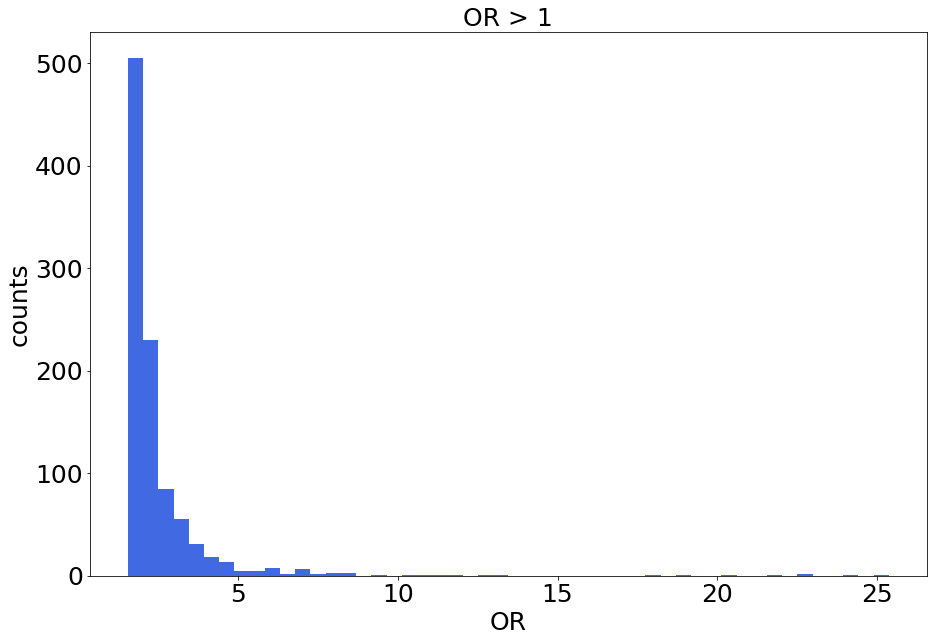

In [53]:
fig, ax = plt.subplots(figsize=(15,10));

plt.hist(OR_above_1['OR'], bins=50, color='royalblue')

ax.set_title('OR > 1', fontsize=25)
ax.set_xlabel('OR', fontsize=25);
ax.set_ylabel('counts', fontsize=25);
ax.tick_params(labelsize=25);

plt.show()

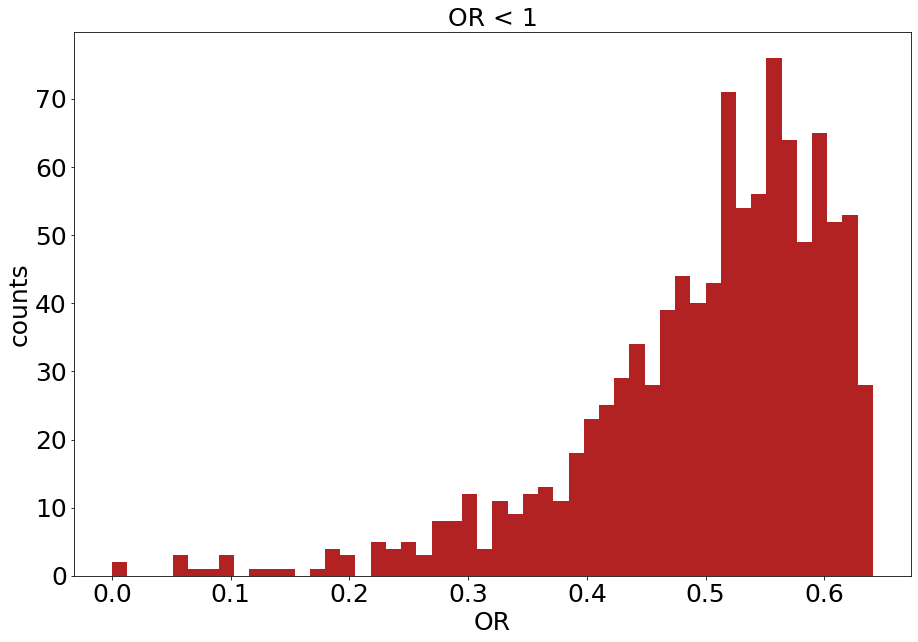

In [54]:
fig, ax = plt.subplots(figsize=(15,10));

plt.hist(OR_below_1['OR'], bins=50, color='firebrick')

ax.set_xlabel('OR', fontsize=25);
ax.set_ylabel('counts', fontsize=25);
ax.tick_params(labelsize=25);
ax.set_title('OR < 1', fontsize=25)

plt.show()

# Correlation sex differences in FC G1 and sex differences in connectivity profiles

In [29]:
# load sex differences in FC G1 results

R_lmer_fc_G1_sex_contrast_res = pd.read_csv(resdir_hcp+'R_lmer_fc_G1_sex_contrast_res.csv')  

## FC G1 abs(t-values) & counts connections showing sex differences per seed region
- sex differences in FC G1: t-values for sex contrast -> absolute value (merging directionality of effects given that for connectivity profile (counts) I do not include this information)
- sex differences in connectivity profiles: counts (sum) of connections showing a significant sex difference per seed region

In [65]:
# with OR = nans ignored for mean calculation
stats.spearmanr(abs(R_lmer_fc_G1_sex_contrast_res.t_val), num_sig_q_vals_per_area)

SpearmanrResult(correlation=0.23878996877517958, pvalue=1.3590683076532116e-06)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.0


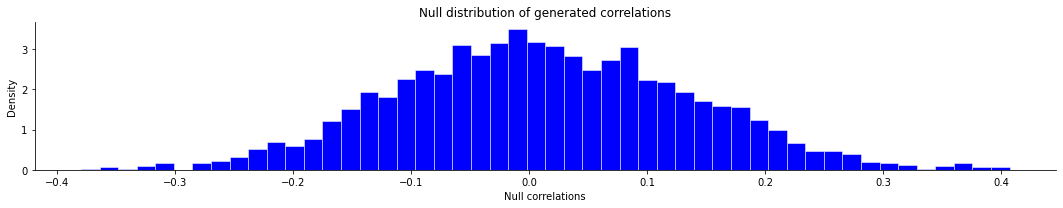

In [67]:
SpinPermutationTest_Schaefer400(x = abs(R_lmer_fc_G1_sex_contrast_res.t_val), y = num_sig_q_vals_per_area, correlation_type = 'spearman')

In [71]:
df_FCabstval_CONNPROcounts = pd.DataFrame({'FC abs(tval)': abs(R_lmer_fc_G1_sex_contrast_res.t_val), 'number of connections showing sex differences per seed region':  num_sig_q_vals_per_area, 'yeo7_networks_array_labels' : yeo7_networks_array_labels})

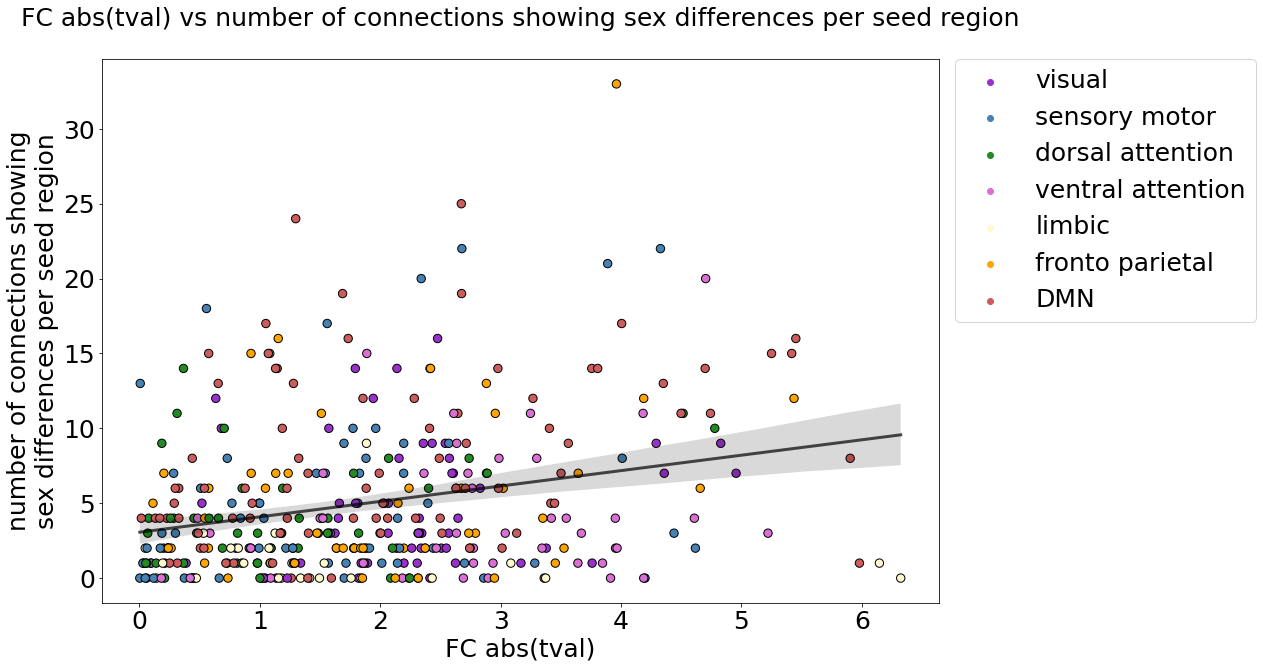

In [73]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(data = df_FCabstval_CONNPROcounts, x = 'FC abs(tval)', y = 'number of connections showing sex differences per seed region', 
                hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                palette=palette_labeled_networks, 
                s=70, 
                edgecolor='black',
                linewidth=1)

sns.regplot(data=df_FCabstval_CONNPROcounts, x = 'FC abs(tval)', y = 'number of connections showing sex differences per seed region', scatter=False, ax=ax, line_kws={"color":"black","alpha":0.7,"lw":3})


ax.axes.set_title(f"FC abs(tval) vs number of connections showing sex differences per seed region", y=1.05, fontsize=25)
ax.set_xlabel("FC abs(tval)",fontsize=25)
ax.set_ylabel("number of connections showing\nsex differences per seed region",fontsize=25)
ax.tick_params(labelsize=25)
ax.legend(fontsize=25, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


# save figure in directory 
#plt.savefig(resdir_fig+'HCP_scatter_corr_fc_G1_geo.png', dpi=300, bbox_inches="tight")  # bbox_inches is so that the figure doesn't get cut off when saving

#
#
#
#
#
#
#
# Examples chord plots

In [252]:
# Load d3blocks
from d3blocks import D3Blocks
#
# Initialize
d3 = D3Blocks()
#
# Load example data
df = d3.import_example('energy')
#
# Plot
d3.chord(df)
#


[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Downloading [energy] dataset from github source..
[d3blocks] >INFO> Extracting files..
[d3blocks] >INFO> Import dataset: [energy]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> Create directory: [/tmp/d3blocks]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html


In [253]:
df

,source,target,weight
0,Agricultural 'waste',Bio-conversion,124.729
1,Bio-conversion,Liquid,0.597
2,Bio-conversion,Losses,26.862
3,Bio-conversion,Solid,280.322
4,Bio-conversion,Gas,81.144
...,...,...,...
63,Thermal generation,District heating,79.329
64,Tidal,Electricity grid,9.452
65,UK land based bioenergy,Bio-conversion,182.010
66,Wave,Electricity grid,19.013


In [262]:
# Load d3blocks
from d3blocks import D3Blocks
#
# Initialize
d3 = D3Blocks(chart='Chord', frame=False)
#
# Import example
df = d3.import_example('energy')
#
# Node properties
d3.set_node_properties(df, opacity=0.2, cmap='tab20')
d3.set_edge_properties(df, color='source', opacity='source')
#
# Show the chart
d3.show()
#
# Make some edits to highlight the Nuclear node
# d3.node_properties
d3.node_properties.get('Nuclear')['color']='#ff0000'
d3.node_properties.get('Nuclear')['opacity']=1
# Show the chart
#
d3.show()
# Make edits to highlight the Nuclear Edge
d3.edge_properties.get(('Nuclear', 'Thermal generation'))['color']='#ff0000'
d3.edge_properties.get(('Nuclear', 'Thermal generation'))['opacity']=0.8
d3.edge_properties.get(('Nuclear', 'Thermal generation'))['weight']=1000
#
# Show the chart
d3.show()

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Extracting files..
[d3blocks] >INFO> Import dataset: [energy]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Convert to Dictionary.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html


# Discarded analyses attempts -> to delete at some point

## FC G1 t-values & mean OR -> TAKING MEAN OR IS NOT REALLY CORRECT
- sex differences in FC G1: t-values for sex contrast
- sex differences in connectivity profiles: mean OR computed for seed region

### with OR = nans ignored for mean calculation

In [53]:
mean_OR_seed = []


for i in range(len(OR_matrix)):
    mean_OR_seed.append(np.nanmean(OR_matrix[i]))
                        
mean_OR_seed = np.array(mean_OR_seed)
    

In [89]:
# with OR = nans ignored for mean calculation
stats.spearmanr(R_lmer_fc_G1_sex_contrast_res.t_val, mean_OR_seed)

SpearmanrResult(correlation=0.24022031387696172, pvalue=1.169554594100194e-06)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.0325


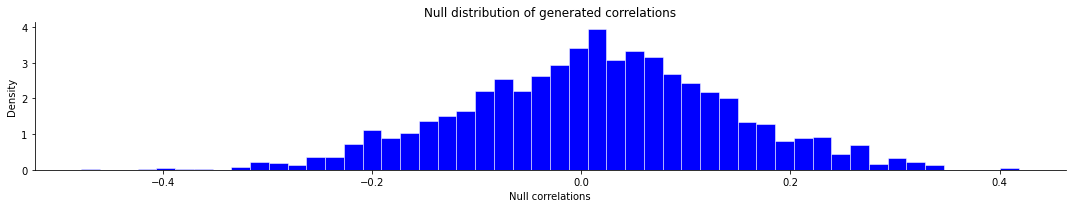

In [ ]:
SpinPermutationTest_Schaefer400(x = R_lmer_fc_G1_sex_contrast_res.t_val, y = mean_OR_seed, correlation_type = 'spearman')

In [56]:
df_FCtval_ORmean = pd.DataFrame({'FC tval': R_lmer_fc_G1_sex_contrast_res.t_val, 'OR mean':  mean_OR_seed, 'yeo7_networks_array_labels' : yeo7_networks_array_labels})

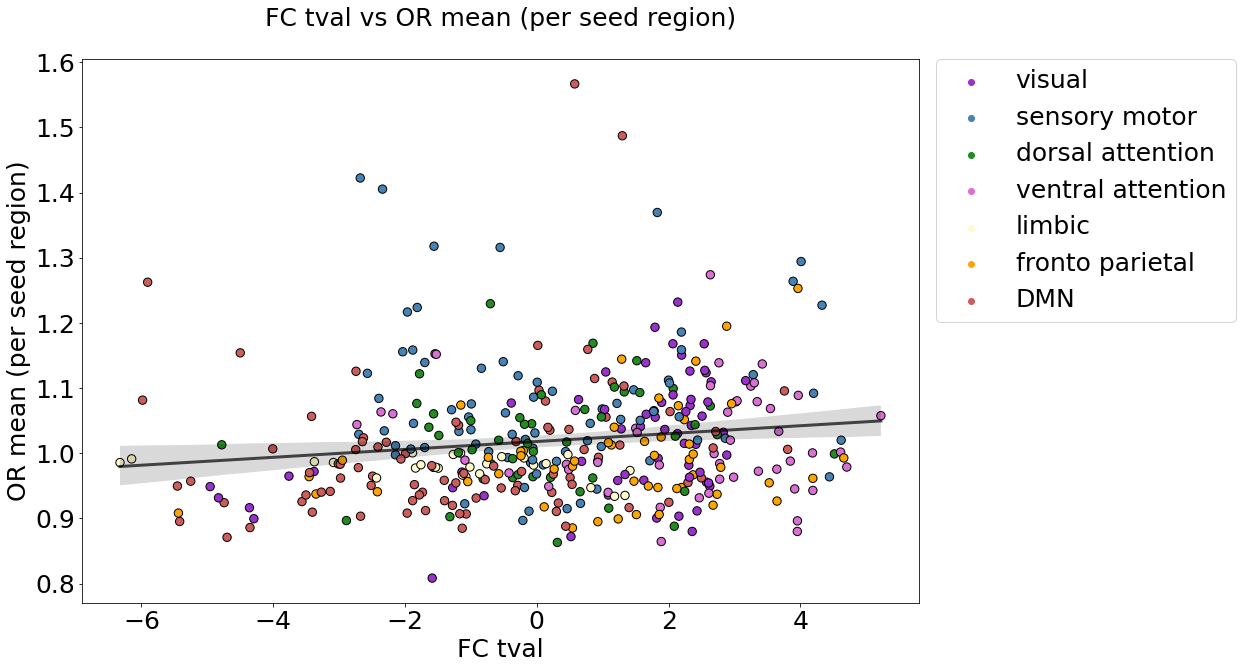

In [57]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(data = df_FCtval_ORmean, x = 'FC tval', y = 'OR mean', 
                hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                palette=palette_labeled_networks, 
                s=70, 
                edgecolor='black',
                linewidth=1)

sns.regplot(data=df_FCtval_ORmean, x = 'FC tval', y = 'OR mean', scatter=False, ax=ax, line_kws={"color":"black","alpha":0.7,"lw":3})


ax.axes.set_title(f"FC tval vs OR mean (per seed region)", y=1.05, fontsize=25)
ax.set_xlabel("FC tval",fontsize=25)
ax.set_ylabel("OR mean (per seed region)",fontsize=25)
ax.tick_params(labelsize=25)
ax.legend(fontsize=25, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


# save figure in directory 
#plt.savefig(resdir_fig+'HCP_scatter_corr_fc_G1_geo.png', dpi=300, bbox_inches="tight")  # bbox_inches is so that the figure doesn't get cut off when saving

### with OR = 1 (instead of nan) - included in the mean calculation

In [53]:
mean_OR_seed = []


for i in range(len(OR_matrix)):
    mean_OR_seed.append(np.nanmean(OR_matrix[i]))
                        
mean_OR_seed = np.array(mean_OR_seed)
    

In [54]:
stats.spearmanr(R_lmer_fc_G1_sex_contrast_res.t_val, mean_OR_seed)

SpearmanrResult(correlation=0.1851086569291058, pvalue=0.00019701830266627302)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.059


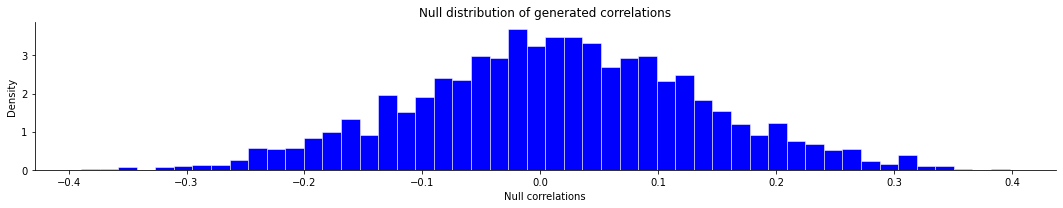

In [55]:
# with OR = 1 (instead of nan) - included in the mean calculation
SpinPermutationTest_Schaefer400(x = R_lmer_fc_G1_sex_contrast_res.t_val, y = mean_OR_seed, correlation_type = 'spearman')

In [56]:
df_FCtval_ORmean = pd.DataFrame({'FC tval': R_lmer_fc_G1_sex_contrast_res.t_val, 'OR mean':  mean_OR_seed, 'yeo7_networks_array_labels' : yeo7_networks_array_labels})

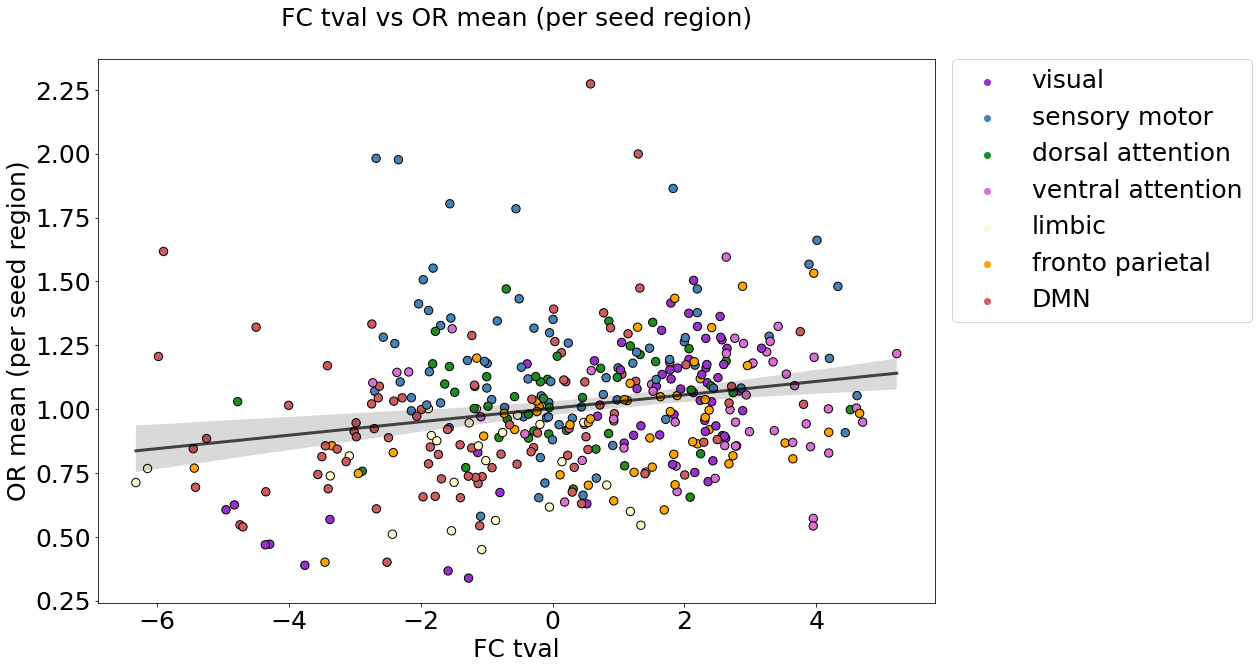

In [88]:
# with OR = 1 (instead of nan) - included in the mean calculation

fig, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(data = df_FCtval_ORmean, x = 'FC tval', y = 'OR mean', 
                hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                palette=palette_labeled_networks, 
                s=70, 
                edgecolor='black',
                linewidth=1)

sns.regplot(data=df_FCtval_ORmean, x = 'FC tval', y = 'OR mean', scatter=False, ax=ax, line_kws={"color":"black","alpha":0.7,"lw":3})


ax.axes.set_title(f"FC tval vs OR mean (per seed region)", y=1.05, fontsize=25)
ax.set_xlabel("FC tval",fontsize=25)
ax.set_ylabel("OR mean (per seed region)",fontsize=25)
ax.tick_params(labelsize=25)
ax.legend(fontsize=25, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


# save figure in directory 
#plt.savefig(resdir_fig+'HCP_scatter_corr_fc_G1_geo.png', dpi=300, bbox_inches="tight")  # bbox_inches is so that the figure doesn't get cut off when saving

# In case I need to play around with computation of contingency table or to understand OR

then can delete

In [157]:
i = 0
j = 4


### creating contingency table with counts of occurances for Chi-square test of indepndence of variables to test if there are statistically significant sex differences in top 10% of fc connections
# C: connection (area) in top 10%; NC: connection (area) not in top 10%; m: male; f: female
# row: male (top), female (bottom)
# columns: C (left), NC right

contingency_table = []
Cm = 0
NCm = 0
Cf = 0
NCf = 0


## male row
Cm = sum(binary_top_fc_M.T[i][j])
NCm = len(binary_top_fc_M) - Cm  # number of male subjects minus sum of counts in the top 10%

# append male row to table
contingency_table.append([Cm, NCm])


## female row
Cf = sum(binary_top_fc_F.T[i][j])
NCf = len(binary_top_fc_F) - Cf  # number of male subjects minus sum of counts in the top 10%

# append female row to table
contingency_table.append([Cf, NCf])

contingency_table = np.array(contingency_table)


# compute Odds Ratio (regardless of pvalue of Chi-square test)
OR = (Cm/NCm)/(Cf/NCf)

# in case the OR == infinity (because dividing by zero), recompute the OR: can replace the 0 at denominator by 0.5 for more interpretability (https://www.researchgate.net/post/How_to_calculate_OR_odd_ratio_if_one_of_groups_is_0_in_a_case-control_study)
if OR == float('inf'):
    OR = (Cm/NCm)/0.5



# only run Chi-square test if there aren't just zeros in both columns (ie either male or female has area as one of top connections (totC > 0) or not all males and all females have area chosen as top connection (totNC > 0) - otherwise throws an error
if (Cm + Cf > 0) and (NCm + NCf > 0):
    ### Chi-square test of independence of variables in a contingency table, [1] indexes the p val
    p_val = stats.chi2_contingency(contingency_table)[1]




/tmp/ipykernel_4312/790154624.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  OR = (Cm/NCm)/(Cf/NCf)


In [158]:
contingency_table

array([[  3, 461],
       [  0, 536]])

In [207]:
Cf

0

In [208]:
NCf

536

In [206]:
Cf/NCf

0.0

In [156]:
(Cm/NCm)/0.5

0.013015184381778741

In [159]:
OR

0.013015184381778741

In [160]:
p_val

0.19890908789151832